In [343]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from dateutil.parser import parse
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append("D:\\Anaconda\\envs\\HYQ\\lib\\site-packages")

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import os
import tempfile

In [345]:
paths =  ['D:\\Anaconda\\envs\\HYQ\\python37.zip',
 'D:\\Anaconda\\envs\\HYQ\\DLLs',
 'D:\\Anaconda\\envs\\HYQ\\lib',
 'D:\\Anaconda\\envs\\HYQ',
 '',
 'C:\\Users\\hyq94\\AppData\\Roaming\\Python\\Python37\\site-packages',
 'D:\\Anaconda\\envs\\HYQ\\lib\\site-packages',
 'D:\\Anaconda\\envs\\HYQ\\lib\\site-packages\\win32',
 'D:\\Anaconda\\envs\\HYQ\\lib\\site-packages\\win32\\lib',
 'D:\\Anaconda\\envs\\HYQ\\lib\\site-packages\\Pythonwin',
 'D:\\Anaconda\\envs\\HYQ\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\hyq94\\.ipython']

for path in paths:
    sys.path.append(path)

In [129]:
train_beh = pd.read_csv('./训练数据集/训练数据集_beh.csv')
train_tag = pd.read_csv('./训练数据集/训练数据集_tag.csv')
train_trd = pd.read_csv('./训练数据集/训练数据集_trd.csv')

result_beh = pd.read_csv('./评分数据集b/b/评分数据集_beh_b.csv')
result_tag = pd.read_csv('./评分数据集b/b/评分数据集_tag_b.csv')
result_trd = pd.read_csv('./评分数据集b/b/评分数据集_trd_b.csv')

In [8]:
tag_desc = pd.read_csv('tag.csv')
beh_desc = pd.read_csv('beh.csv')
trd_desc = pd.read_csv('trd.csv')

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
# 查询空缺值和 \\N 值
def check_nan(dataframe):
    print(f"{'col_name': <50} | {'nan_num': ^5} | {'null_type': ^5}")
    print('-'*54)

    for col in dataframe:
        if dataframe[col].isnull().any():
            null_type = 'nan'
            num = dataframe[dataframe[col].isnull() == True].shape[0]
            print(f"{col: <50} | {num: >7} | {null_type: >7}")
        else:
            null_type = 'Not null'
            num = dataframe[dataframe[col] == '\\N'].shape[0]
            if num != 0:
                null_type = '\\N'
            print(f"{col: <50} | {num: >7} | {null_type: >7}")
    return

# 查询特征定义
def data_def(df, col):
    defi = df.loc[df['字段'] == col]
    defi = defi['名称']
    print(col+': '+defi)

# 列唯一值
def unique(df, col):
    unique = set(df[col].tolist())
    return('unique_num:',len(unique),'unique_set:',list(unique))

# onehot encoding
from sklearn.preprocessing import OneHotEncoder

def col2onehot(df, col):
    onehot = df[[col]]
    cat_encoder = OneHotEncoder(sparse = False)
    df_onehot = cat_encoder.fit_transform(onehot)
    df_onehot = pd.DataFrame(df_onehot)
    df_onehot.columns = cat_encoder.categories_[0]
    rename_onehot(df_onehot, col)
    df = pd.concat([df, df_onehot], axis = 1)
    return df

# 唯一用户持卡、人口特征数据

- 预测集与训练集用户不重叠

In [5]:
train_tag.head(5) # 用户唯一

,id,flag,gdr_cd,age,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,job_year,ic_ind,...,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl
0,U7A4BAD,0,M,41,B,B,Z,NaN,3,0,...,-1,0,0,0,3,1,0,3492,-1,10
1,U557810,0,M,35,A,NaN,G,NaN,4,0,...,-1,0,0,0,1,1,0,4575,-1,10
2,U1E9240,0,M,53,B,A,C,C,9,0,...,-1,0,0,0,7,2,0,4894,-1,40
3,U6DED00,0,F,41,B,NaN,Z,NaN,0,0,...,-1,0,0,0,1,1,0,4938,-1,10
4,UDA8E28,0,F,42,B,B,Z,B,3,1,...,-1,0,0,0,2,7,0,2378,-1,20


In [11]:
def processing(df_tag):
    gender_mapping = {'F': 1,'M': 0,'\\N':-1}
    df_tag['gdr_cd'] = df_tag["gdr_cd"].map(gender_mapping)
    df_tag['edu_deg_cd'] = df_tag['edu_deg_cd'].fillna('\\N')
    df_tag['acdm_deg_cd'] = df_tag['acdm_deg_cd'].fillna('\\N')
    df_tag['deg_cd'] = df_tag['deg_cd'].fillna('nan')
    
    col_name = ['id', 'flag', 'gdr_cd', 'age', 'mrg_situ_cd', 'edu_deg_cd', 'acdm_deg_cd', 'deg_cd']
    for col in df_tag.columns:
        if col not in col_name:
            fil = (df_tag[col] == '\\N') | (df_tag[col].isnull())
            df_tag.loc[fil, col] = -10
            #df_tag.loc[df_tag[col].isnull(), col] = -20
            df_tag[col] = df_tag[col].astype(int)
    return df_tag

In [12]:
onehotcol = ['mrg_situ_cd','edu_deg_cd','acdm_deg_cd','deg_cd']
def toonehot(df, cols):
    for col in cols:
        df = col2onehot(df, col)
    return df

In [13]:
def rename_onehot(df, name):
    for col in df.columns:
        df.rename(columns = {col: name+'_'+col}, inplace = True)

In [14]:
# 第一步: tag
def step1(df_tag):
    df_copy = processing(df_tag)
    df_copy = toonehot(df_copy, onehotcol)
    df_copy.drop(onehotcol, axis = 1, inplace = True)
    return df_copy

# 第一步

In [130]:
#step 1
df_train_tag = step1(train_tag)
df_train_tag.drop(['edu_deg_cd_J'], axis = 1, inplace = True) # result中不包含这一列
result_df1 = step1(result_tag)

D:\Anaconda\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
D:\Anaconda\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [17]:
df_train_tag.shape

(39923, 73)

In [18]:
result_df1.shape

(6000, 72)

In [193]:
for col in df_train_tag.columns.tolist():
    if col not in result_df1.columns.tolist():
        print(col)

flag
edu_deg_cd_J


In [163]:
s = 2
for col in train_tag.columns[2:]:
    if type(train_tag[col][0]) == str:
        print(s)
        print(col)
        print(data_def(tag_desc, col))
        print(unique(train_tag, col))
        print('-'*40)
        s += 1
    else:
        print(s)
        print(col)
        print(data_def(tag_desc, col))
        print('-'*40)
        s += 1

2
gdr_cd
13    gdr_cd: 性别
Name: 名称, dtype: object
None
----------------------------------------
3
age
12    age: 年龄
Name: 名称, dtype: object
None
----------------------------------------
4
mrg_situ_cd
14    mrg_situ_cd: 婚姻
Name: 名称, dtype: object
None
('unique_num:', 6, 'unique_set:', ['Z', 'B', 'O', 'A', '\\N', '~'])
----------------------------------------
5
edu_deg_cd
15    edu_deg_cd: 教育程度
Name: 名称, dtype: object
None
('unique_num:', 14, 'unique_set:', ['G', 'C', 'F', 'Z', 'B', 'A', '\\N', 'K', 'M', 'J', 'nan', 'D', 'L', '~'])
----------------------------------------
6
acdm_deg_cd
16    acdm_deg_cd: 学历
Name: 名称, dtype: object
None
('unique_num:', 9, 'unique_set:', ['G', 'C', 'F', 'Z', '30', '\\N', 'nan', 'D', '31'])
----------------------------------------
7
deg_cd
17    deg_cd: 学位
Name: 名称, dtype: object
None
('unique_num:', 8, 'unique_set:', ['C', 'Z', 'B', 'A', '\\N', 'nan', 'D', '~'])
----------------------------------------
8
job_year
18    job_year: 工作年限
Name: 名称, dtype: objec

In [164]:
s = 1
for col in result_tag.columns[1:]:
    if type(result_tag[col][0]) == str:
        print(s)
        print(col)
        print(data_def(tag_desc, col))
        print(unique(train_tag, col))
        print('-'*40)
        s += 1
    else:
        print(s)
        print(col)
        print(data_def(tag_desc, col))
        print('-'*40)
        s += 1

1
gdr_cd
13    gdr_cd: 性别
Name: 名称, dtype: object
None
----------------------------------------
2
age
12    age: 年龄
Name: 名称, dtype: object
None
----------------------------------------
3
mrg_situ_cd
14    mrg_situ_cd: 婚姻
Name: 名称, dtype: object
None
('unique_num:', 6, 'unique_set:', ['Z', 'B', 'O', 'A', '\\N', '~'])
----------------------------------------
4
edu_deg_cd
15    edu_deg_cd: 教育程度
Name: 名称, dtype: object
None
('unique_num:', 14, 'unique_set:', ['G', 'C', 'F', 'Z', 'B', 'A', '\\N', 'K', 'M', 'J', 'nan', 'D', 'L', '~'])
----------------------------------------
5
acdm_deg_cd
16    acdm_deg_cd: 学历
Name: 名称, dtype: object
None
('unique_num:', 9, 'unique_set:', ['G', 'C', 'F', 'Z', '30', '\\N', 'nan', 'D', '31'])
----------------------------------------
6
deg_cd
17    deg_cd: 学位
Name: 名称, dtype: object
None
('unique_num:', 8, 'unique_set:', ['C', 'Z', 'B', 'A', '\\N', 'nan', 'D', '~'])
----------------------------------------
7
job_year
18    job_year: 工作年限
Name: 名称, dtype: objec

In [199]:
unique(train_tag, 'l1y_crd_card_csm_amt_dlm_cd')

('unique_num:', 7, 'unique_set:', [0, 1, 2, 3, 4, 5, -10])

In [195]:
train_1 =  df_train_tag.loc[df_train_tag['flag'] == 1]
train_0 = df_train_tag.loc[df_train_tag['flag'] == 0]

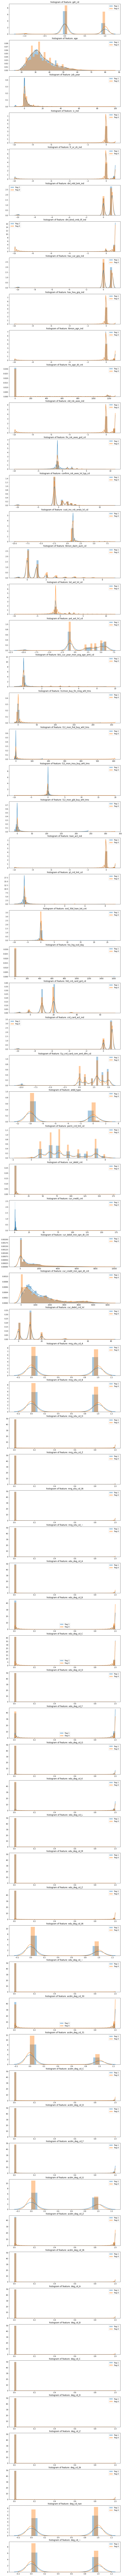

In [196]:
plt.figure(figsize=(12,72*4))
gs = gridspec.GridSpec(72, 1)
for i, col in enumerate(df_train_tag.columns[2:]):
    ax = plt.subplot(gs[i])
    sns.distplot(train_1[col].to_numpy(),label = 'flag 1')
    sns.distplot(train_0[col].to_numpy(),label = 'flag 0')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(col))
    ax.legend(loc = 'best')
plt.show()

In [69]:
tag_desc

,序号,字段,名称
0,1,id,用户标识
1,2,flag,目标变量
2,3,cur_debit_cnt,持有招行借记卡张数
3,4,cur_credit_cnt,持有招行信用卡张数
4,5,cur_debit_min_opn_dt_cnt,持有招行借记卡天数
5,6,cur_credit_min_opn_dt_cnt,持有招行信用卡天数
6,7,cur_debit_crd_lvl,招行借记卡持卡最高等级代码
7,8,hld_crd_card_grd_cd,招行信用卡持卡最高等级代码
8,9,crd_card_act_ind,信用卡活跃标识
9,10,l1y_crd_card_csm_amt_dlm_cd,最近一年信用卡消费金额分层


# 用户APP行为数据-30days-6.1~6.30

### 30天
- 30天内每位用户浏览app总页数
- 30天内每位用户浏览app的unique页数
- 30天内每位用户最早浏览app的日期
- 30天内每位用户最后一次浏览app的日期
- 30天内每位用户最早和最晚浏览app的间隔时间
- 30天内每位用户两次浏览app的最短时间间隔
- 30天内每位用户两次浏览app的最长时间间隔
- 30天内每位用户浏览app的次数（按天）
- 30天浏览app的总时长
- 30天内浏览app每个页面的次数

### 每日
- 每日浏览总页数的均值、最大值、最小值、方差
- 每日浏览unique的页数的均值、最大值、最小值、方差
- 每日浏览app时长（最晚-最早）的均值、最大值、最小值、方差

In [131]:
train_beh.drop('page_tm',axis = 1, inplace = True)
train_beh.rename(columns={'Unnamed: 3':'page_tm'},inplace = True)

In [132]:
result_beh.drop('page_tm',axis = 1, inplace = True)
result_beh.rename(columns={'Unnamed: 2':'page_tm'},inplace = True)

In [35]:
train_beh.head(19).sort_values(by = ['page_tm'], ascending = True)

,id,flag,page_no,page_tm
14,U64F0C9,0,CQA,2019-06-17 13:49:54
5,U64F0C9,0,CQE,2019-06-17 13:50:02
4,U64F0C9,0,AAO,2019-06-17 13:50:08
12,U64F0C9,0,AAO,2019-06-17 13:50:08
3,U64F0C9,0,CQE,2019-06-17 13:50:12
10,U64F0C9,0,SZA,2019-06-17 13:50:16
6,U64F0C9,0,CQA,2019-06-17 13:51:13
11,U64F0C9,0,CQA,2019-06-25 16:15:07
1,U64F0C9,0,CQE,2019-06-25 16:15:11
15,U64F0C9,0,CQE,2019-06-25 16:15:28


In [141]:
beh_desc

,序号,字段,名称,码值
0,1,id,用户标识,NaN
1,2,flag,目标变量,"1标识正样本,0标识负样本"
2,3,page_no,页面编码,标识招商银行APP上\n某页面的3位字符编码
3,4,page_tm,访问时间,NaN


In [21]:
# APP数据
def step2_pre(df_beh):
    df_beh['page_tm']=pd.to_datetime(df_beh['page_tm'],format='%Y-%m-%d %H:%M:%S')
    df_beh['page_date'] = df_beh['page_tm'].dt.date
    df_beh['page_time'] = df_beh['page_tm'].dt.time
    return

In [22]:
def to_timestamp(df, col, FMT):
    return df[col].apply(lambda x:datetime.strptime(str(x), FMT))

In [23]:
# 30天内每位用户两次浏览app的最短时间间隔
# 30天内每位用户两次浏览app的最长时间间隔
def day30interval(df_beh):
    interval_2 = df_beh.groupby(['id','page_date'])['page_time'].count().reset_index()
    interval_2_1 = interval_2.groupby(['id']).apply(lambda x: x.sort_values('page_date'))
    interval_2_1.columns = ['uni_id','page_date','page_time']
    interval_2_1['page_date_sequel'] = interval_2_1.groupby(['id'])['page_date'].shift(1)
    interval_2_1['sequel'] = interval_2_1['page_date'] - interval_2_1['page_date_sequel']
    interval_2_1['sequel_max'] = interval_2_1['sequel'].fillna(pd.Timedelta(days=-10))
    interval_2_1['sequel_min'] = interval_2_1['sequel'].fillna(pd.Timedelta(days=999))
    interval_2_max = interval_2_1.groupby(['id'])['sequel_max'].max().to_frame().reset_index()
    interval_2_min = interval_2_1.groupby(['id'])['sequel_min'].min().to_frame().reset_index()
    return interval_2_max, interval_2_min

In [24]:
# app行为数据
def step2_day30(df_beh):
    dfs = []
    # 30天内每位用户浏览app的unique页面种类数量
    uniquepage_30days = df_beh.groupby(['id'])['page_no'].nunique().rename('unipage_num').to_frame().reset_index()
    dfs.append(uniquepage_30days)
    
# 30天内每位用户最早浏览app的日期
# 30天内每位用户最后一次浏览app的日期
# 30天内每位用户最早和最晚浏览app的间隔时间
    interval_min_30 = df_beh.groupby(['id'])['page_date'].min().to_frame().reset_index()
    interval_max_30 = df_beh.groupby(['id'])['page_date'].max().to_frame().reset_index()
    interval_30 = pd.merge(interval_min_30, interval_max_30, how = 'left', on = 'id')
    interval_30.columns = ['id', 'date_min', 'date_max']
    interval_30['max_interval'] = interval_30['date_max'] - interval_30['date_min']
    dfs.append(interval_30[['id','max_interval']])

# 30天每位用户浏览app的最短/最长日时长
# 30天总时长
# 30天内登录app天数
    app_time_min = df_beh.groupby(['id','page_date'])['page_time'].min().to_frame().reset_index()
    app_time_max = df_beh.groupby(['id','page_date'])['page_time'].max().to_frame().reset_index()
    app_totaltime = pd.merge(app_time_min, app_time_max, how = 'left', on = ['id','page_date'])
    app_totaltime.columns = ['id','page_date', 'time_min', 'time_max']
    app_totaltime['total_time'] = to_timestamp(app_totaltime, 'time_max', '%H:%M:%S') - to_timestamp(app_totaltime, 'time_min', '%H:%M:%S') 
    app_sumtime = app_totaltime.groupby(['id'])['total_time'].sum().to_frame().reset_index()
    app_desctime = app_totaltime.groupby(['id']).agg(['min','max','sum','count']).reset_index()
    app_desctime.columns = ['id', 'min_daytime','max_daytime','sum_daytime','count_login_days']
    dfs.append(app_desctime)
    
# 30天内每位用户浏览app总页数
# 30天内点击app每个页面的次数
    page_times = df_beh.groupby(['id','page_no'])['page_tm'].count().to_frame().reset_index()
    page_cols = unique(page_times,'page_no')[3]

    for column in page_cols:
        page_times.loc[page_times['page_no'].str.contains(column), column+'_num'] = page_times['page_tm']
        page_times[column+'_num'].fillna(0, inplace = True)
    
    page_times = page_times.drop(['page_no'], axis = 1).groupby(['id']).agg(['sum']).reset_index()
    dfs.append(page_times)
    
    interval_2_max, interval_2_min = day30interval(df_beh)
    dfs.append(interval_2_max)
    dfs.append(interval_2_min)
    
    # 每位用户日点击页面数的平均值、最小值、最大值、标准差
    daily_click = df_beh.groupby(['id','page_date'])['page_time'].count().to_frame().reset_index()
    daily_click = daily_click[['id','page_time']].groupby(['id']).agg(['min','max','std','mean']).reset_index()
    daily_click.fillna(0, inplace = True)
    dfs.append(daily_click)
    
    # 每位用户日点击unique页面数的平均值、最小值、最大值、标准差
    daily_uniclick = df_beh.groupby(['id','page_date'])['page_no'].nunique().rename('unipage').to_frame().reset_index()
    daily_uniclick = daily_uniclick[['id','unipage']].groupby(['id']).agg(['min','max','std','mean']).reset_index()
    daily_uniclick.fillna(0, inplace = True)
    dfs.append(daily_uniclick)
    
    return dfs

In [25]:
def combine(df_from_step1, dfs):    
    # 合并数据
    df_step2 = df_from_step1.copy()
    for df in dfs:
        df_step2 = pd.merge(df_step2, df, how = 'left', on = 'id')

    try:
        df_step2.fillna(0, inplace = True)
    except:
        df_step2.fillna(pd.Timedelta(seconds=0), inplace = True)
        
    return df_step2

# 第二步

In [133]:
step2_pre(train_beh)

In [134]:
dfs = step2_day30(train_beh)

In [135]:
train_tag_comb = combine(df_train_tag, dfs)

D:\Anaconda\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
D:\Anaconda\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [136]:
step2_pre(result_beh)

In [137]:
dfs_result = step2_day30(result_beh)

In [138]:
result_df2 = combine(result_df1, dfs_result)

In [32]:
train_tag_comb.shape

(39923, 119)

In [33]:
result_df2.shape

(6000, 118)

D:\Anaconda\lib\site-packages\seaborn\distributions.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return int(np.ceil((a.max() - a.min()) / h))


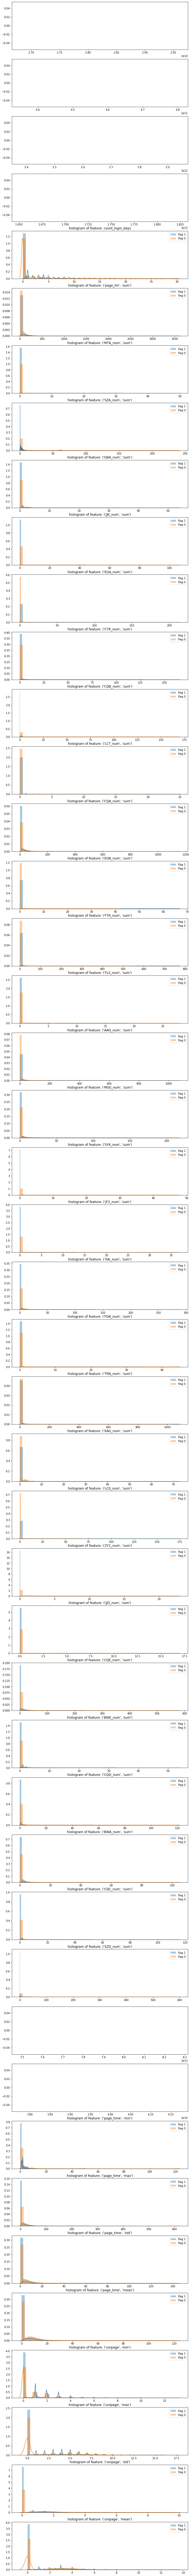

In [215]:
train_11 =  train_tag_comb.loc[train_tag_comb['flag'] == 1]
train_00 = train_tag_comb.loc[train_tag_comb['flag'] == 0]

plt.figure(figsize=(12,45*4))
gs = gridspec.GridSpec(45, 1)
for i, col in enumerate(train_tag_comb.columns[74:]):
    try:
        ax = plt.subplot(gs[i])
        sns.distplot(train_11[col].to_numpy(),label = 'flag 1')
        sns.distplot(train_00[col].to_numpy(),label = 'flag 0')
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(col))
        ax.legend(loc = 'best')
    except:
        continue
plt.show()

# 用户交易记录-60days-5.1~6.30

## 两个月
- 两个月支出笔数
- 两个月支出总额
- 两个月收入笔数
- 两个月收入总额
- 两个月流水笔数
- 两个月流水总额
- 三类支付方式笔数
- 支出中三类支付方式分别的笔数
- 收入中三类支付方式分别的笔数

In [251]:
trd_desc

,序号,字段,名称,码值,备注
0,1,id,用户标识,NaN,NaN
1,2,flag,目标变量,"1标识正样本,0标识负样本",评分数据集中无该字段
2,3,Dat_Flg1_Cd,交易方向,收支交易方向，\nB：支出；C：收入,NaN
3,4,Dat_Flg3_Cd,支付方式,NaN,NaN
4,5,Trx_Cod1_Cd,收支一级分类代码,NaN,NaN
5,6,Trx_Cod2_Cd,收支二级分类代码,NaN,NaN
6,7,trx_tm,交易时间,NaN,NaN
7,8,cny_trx_amt,交易金额,NaN,折人民币交易金额


In [14]:
train_trd.head(5)

,id,flag,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
0,UFDC88A,0,B,B,1,116,2019-06-20 07:15:28,-127.99
1,UFDC88A,0,B,B,1,116,2019-06-16 10:09:13,-55.88
2,UFDC88A,0,B,B,1,136,2019-05-14 16:11:32,-557.00
3,UFDC88A,0,B,B,1,136,2019-05-19 21:54:40,-77.80
4,UFDC88A,0,B,B,1,113,2019-06-18 08:23:59,-271.62


In [56]:
unique(train_trd, 'Trx_Cod1_Cd')

('unique_num:', 3, 'unique_set:', [1, 2, 3])

In [34]:
def step3_pre(df_trd):
    df_trd['trx_tm']=pd.to_datetime(df_trd['trx_tm'],format='%Y-%m-%d %H:%M:%S')
    df_trd['trx_date'] = df_trd['trx_tm'].dt.date
    df_trd['trx_time'] = df_trd['trx_tm'].dt.time
    return

In [35]:
# 交易数据
def step3(df):
    dfs = []
# 两个月支出笔数
    out = df.loc[df['Dat_Flg1_Cd'] == 'B']
    out_total = out[['id','cny_trx_amt']].groupby(['id'])['cny_trx_amt'].count().rename('out_num').to_frame().reset_index()
    dfs.append(out_total)
# 日支出额度总额、平均值、最大值、最小值、标准差  
# 日支出笔数总额、平均值、最大值、最小值、标准差  
    daily_out = out[['id','trx_date','cny_trx_amt']].groupby(['id','trx_date']).agg(['sum','count']).reset_index()
    daily_out.drop(['trx_date'], axis = 1, inplace = True)
    daily_out = daily_out.groupby(['id']).agg(['sum','mean','max','min','std']).reset_index()
    daily_out.fillna(0,  inplace = True)
    daily_out.columns = ['id','out_total','out_amo_mean','out_amo_max','out_amo_min','out_amo_std','out_con_total','out_con_mean','out_con_max','out_con_min','out_con_std',]
    dfs.append(daily_out)
    
# 两个月收入笔数
    in_ = df.loc[df['Dat_Flg1_Cd'] == 'C']
    in_total = in_[['id','cny_trx_amt']].groupby(['id'])['cny_trx_amt'].count().rename('in_num').to_frame().reset_index()
    dfs.append(in_total)
# 日收入额度总额、平均值、最大值、最小值、标准差  
# 日收入笔数总额、平均值、最大值、最小值、标准差      
    daily_in = in_[['id','trx_date','cny_trx_amt']].groupby(['id','trx_date']).agg(['sum','count']).reset_index()
    daily_in.drop(['trx_date'], axis = 1, inplace = True)
    daily_in = daily_in.groupby(['id']).agg(['sum','mean','max','min','std']).reset_index()
    daily_in.fillna(0,  inplace = True)
    daily_in.columns = ['id','in_total','in_amo_mean','in_amo_max','in_amo_min','in_amo_std','in_con_total','in_con_mean','in_con_max','in_con_min','in_con_std',]
    dfs.append(daily_in)
    
# 两个月流水笔数
# 两个月流水总额
    flow_num = df.groupby(['id'])['cny_trx_amt'].agg(['sum','count']).reset_index()
    flow_num.columns = ['id','flow_amount','flow_num']
    dfs.append(flow_num)

# 三类支付方式笔数 & 金额
    payA = df.loc[df['Dat_Flg3_Cd'] == 'A']
    payA_num = payA.groupby(['id'])['cny_trx_amt'].agg(['count','sum']).reset_index()
    payA_num.columns = ['id','A_num','A_amount']
    dfs.append(payA_num)
    
    payB = df.loc[df['Dat_Flg3_Cd'] == 'B']
    payB_num = payB.groupby(['id'])['cny_trx_amt'].agg(['count','sum']).reset_index()
    payB_num.columns = ['id','B_num','B_amount']
    dfs.append(payB_num)
    
    payC = df.loc[df['Dat_Flg3_Cd'] == 'C']
    payC_num = payC.groupby(['id'])['cny_trx_amt'].agg(['count','sum']).reset_index()
    payC_num.columns = ['id','C_num','C_amount']
    dfs.append(payC_num)

# 收支一级分类中三类支分别的流水笔数和净额
    level1 = df.loc[df['Trx_Cod1_Cd'] == 1]
    level1_num = level1.groupby(['id'])['cny_trx_amt'].agg(['count','sum']).reset_index()
    level1_num.columns = ['id','le1_num','le1_amount']
    dfs.append(level1_num)
    
    level2 = df.loc[df['Trx_Cod1_Cd'] == 2]
    level2_num = level2.groupby(['id'])['cny_trx_amt'].agg(['count','sum']).reset_index()
    level2_num.columns = ['id','le2_num','le2_amount']
    dfs.append(level2_num)
    
    level3 = df.loc[df['Trx_Cod1_Cd'] == 3]
    level3_num = level3.groupby(['id'])['cny_trx_amt'].agg(['count','sum']).reset_index()
    level3_num.columns = ['id','le3_num','le3_amount']
    dfs.append(level3_num)

    return dfs

In [36]:
# 合并数据
def combine_trd(dfs, df_from_step2):
    df_step3 = df_from_step2.copy()
    for df in dfs:
        df_step3 = pd.merge(df_step3, df, how = 'left', on = 'id')

    try:
        df_step3.fillna(0, inplace = True)
    except:
        df_step3.fillna(pd.Timedelta(seconds=0), inplace = True)
    
    return df_step3

In [139]:
step3_pre(train_trd)

In [140]:
dfs_train = step3(train_trd)

In [141]:
train_trd_comb = combine_trd(dfs_train, train_tag_comb)

In [142]:
step3_pre(result_trd)

In [143]:
dfs_result3 = step3(result_trd)

In [144]:
result_df3 = combine_trd(dfs_result3, result_df2)

In [43]:
train_trd_comb.shape

(39923, 155)

In [44]:
result_df3.shape

(6000, 154)

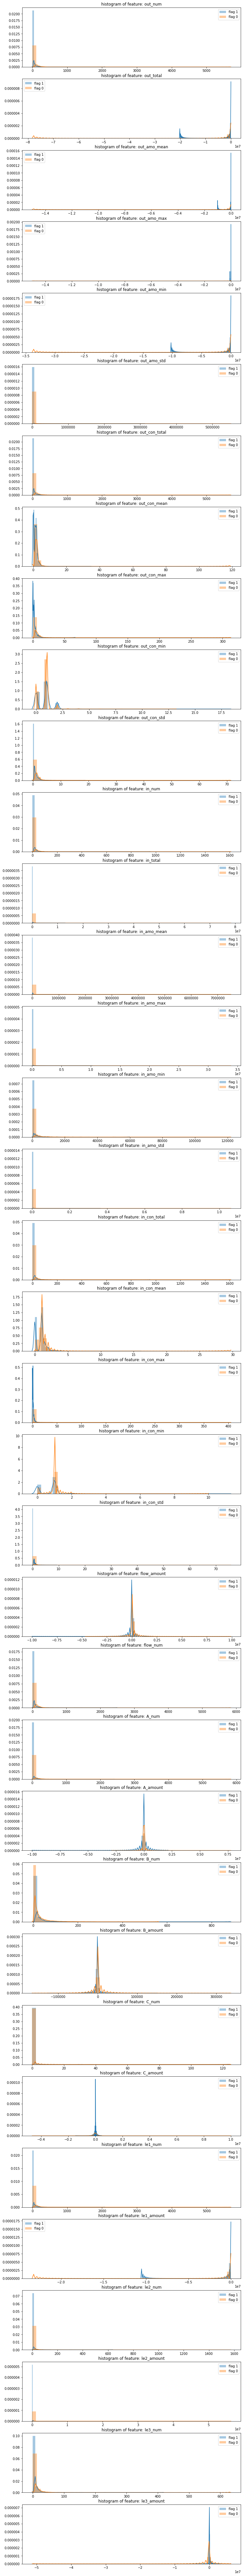

In [234]:
train_111 =  train_trd_comb.loc[train_trd_comb['flag'] == 1]
train_000 = train_trd_comb.loc[train_trd_comb['flag'] == 0]

plt.figure(figsize=(12,36*4))
gs = gridspec.GridSpec(36, 1)
for i, col in enumerate(train_trd_comb.columns[119:]):
    try:
        ax = plt.subplot(gs[i])
        sns.distplot(train_111[col].to_numpy(),label = 'flag 1')
        sns.distplot(train_000[col].to_numpy(),label = 'flag 0')
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(col))
        ax.legend(loc = 'best')
    except:
        continue
plt.show()

In [261]:
train_trd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367211 entries, 0 to 1367210
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1367211 non-null  object        
 1   flag         1367211 non-null  int64         
 2   Dat_Flg1_Cd  1367211 non-null  object        
 3   Dat_Flg3_Cd  1367211 non-null  object        
 4   Trx_Cod1_Cd  1367211 non-null  int64         
 5   Trx_Cod2_Cd  1367211 non-null  int64         
 6   trx_tm       1367211 non-null  datetime64[ns]
 7   cny_trx_amt  1367211 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 83.4+ MB


In [15]:
result_trd.head(5)

,id,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
0,U984422,B,B,1,136,2019-06-23 09:39:27,-119.0
1,U984422,B,B,1,136,2019-06-27 13:56:11,-360.0
2,U984422,B,B,1,136,2019-06-23 09:57:00,-197.0
3,U984422,B,B,1,103,2019-06-20 18:16:38,-24.0
4,U984422,B,B,1,103,2019-06-16 07:36:50,-7.0


In [55]:
print('train_tag')
print(check_num(train_tag))
print('\n','train_beh')
print(check_num(train_beh))
print('\n','train_trd')
print(check_num(train_trd))

train_tag
col_name        | nan_num
-------------------------
edu_deg_cd      |   12436
acdm_deg_cd     |       1
deg_cd          |   20963
atdd_type       |   23657
None

 train_beh
col_name        | nan_num
-------------------------
page_tm         |  934282
None

 train_trd
col_name        | nan_num
-------------------------
None


In [12]:
train_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39923 entries, 0 to 39922
Data columns (total 43 columns):
id                                 39923 non-null object
flag                               39923 non-null int64
gdr_cd                             39923 non-null object
age                                39923 non-null int64
mrg_situ_cd                        39923 non-null object
edu_deg_cd                         27487 non-null object
acdm_deg_cd                        39922 non-null object
deg_cd                             18960 non-null object
job_year                           39923 non-null object
ic_ind                             39923 non-null object
fr_or_sh_ind                       39923 non-null object
dnl_mbl_bnk_ind                    39923 non-null object
dnl_bind_cmb_lif_ind               39923 non-null object
hav_car_grp_ind                    39923 non-null object
hav_hou_grp_ind                    39923 non-null object
l6mon_agn_ind                      399

In [89]:
train_beh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934282 entries, 0 to 934281
Data columns (total 4 columns):
id         934282 non-null object
flag       934282 non-null int64
page_no    934282 non-null object
page_tm    934282 non-null object
dtypes: int64(1), object(3)
memory usage: 28.5+ MB


In [90]:
train_trd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367211 entries, 0 to 1367210
Data columns (total 8 columns):
id             1367211 non-null object
flag           1367211 non-null int64
Dat_Flg1_Cd    1367211 non-null object
Dat_Flg3_Cd    1367211 non-null object
Trx_Cod1_Cd    1367211 non-null int64
Trx_Cod2_Cd    1367211 non-null int64
trx_tm         1367211 non-null object
cny_trx_amt    1367211 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 83.4+ MB


In [235]:
train_trd_comb

,id,flag,gdr_cd,age,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,mrg_situ_cd_A,mrg_situ_cd_B,mrg_situ_cd_O,mrg_situ_cd_Z,mrg_situ_cd_\N,mrg_situ_cd_~,edu_deg_cd_A,edu_deg_cd_B,edu_deg_cd_C,edu_deg_cd_D,edu_deg_cd_F,edu_deg_cd_G,edu_deg_cd_K,edu_deg_cd_L,edu_deg_cd_M,edu_deg_cd_Z,edu_deg_cd_\N,edu_deg_cd_~,acdm_deg_cd_30,acdm_deg_cd_31,acdm_deg_cd_C,acdm_deg_cd_D,acdm_deg_cd_F,acdm_deg_cd_G,acdm_deg_cd_Z,acdm_deg_cd_\N,deg_cd_A,deg_cd_B,deg_cd_C,deg_cd_D,deg_cd_Z,deg_cd_\N,deg_cd_nan,deg_cd_~,unipage_num,max_interval,min_daytime,max_daytime,sum_daytime,count_login_days,"(page_tm, sum)","(MTA_num, sum)","(SZA_num, sum)","(GBA_num, sum)","(JJK_num, sum)","(EGA_num, sum)","(CTR_num, sum)","(CQB_num, sum)","(LCT_num, sum)","(CQA_num, sum)","(EGB_num, sum)","(FTR_num, sum)","(FLS_num, sum)","(AAO_num, sum)","(MSG_num, sum)","(SYK_num, sum)","(JF2_num, sum)","(XAI_num, sum)","(FDA_num, sum)","(TRN_num, sum)","(XAG_num, sum)","(LC0_num, sum)","(ZY1_num, sum)","(JJD_num, sum)","(CQE_num, sum)","(BWE_num, sum)","(CQD_num, sum)","(BWA_num, sum)","(CQC_num, sum)","(SZD_num, sum)",sequel_max,sequel_min,"(page_time, min)","(page_time, max)","(page_time, std)","(page_time, mean)","(unipage, min)","(unipage, max)","(unipage, std)","(unipage, mean)",out_num,out_total,out_amo_mean,out_amo_max,out_amo_min,out_amo_std,out_con_total,out_con_mean,out_con_max,out_con_min,out_con_std,in_num,in_total,in_amo_mean,in_amo_max,in_amo_min,in_amo_std,in_con_total,in_con_mean,in_con_max,in_con_min,in_con_std,flow_amount,flow_num,A_num,A_amount,B_num,B_amount,C_num,C_amount,le1_num,le1_amount,le2_num,le2_amount,le3_num,le3_amount
0,U7A4BAD,0,0,41,3,0,0,0,1,0,0,0,-1,0,-1,4,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,0,3,1,0,3492,-1,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0 days,00:00:00,00:00:00,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days,0 days,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,-15000.00,-15000.00000,-15000.0,-15000.0,0.000000,1.0,1.000,1.0,1.0,0.000000,2.0,17400.00,8700.000000,10000.0,7400.00,1838.477631,2.0,1.000000,1.0,1.0,0.000000,2400.00,3.0,0.0,0.00,0.0,0.00,3.0,2400.0,1.0,-15000.00,2.0,17400.00,0.0,0.0
1,U557810,0,0,35,4,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,1,1,0,4575,-1,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0 days,00:00:00,00:00:00,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days,0 days,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00000,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
2,U1E9240,0,0,53,9,0,0,1,1,0,0,1,935,1,3,3,6,7,-1,2,8,6,0,0,0,0,0,0,0,-1,0,0,0,7,2,0,4894,-1,40,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,25 days,00:00:09,00:03:58,00:08:24,4.0,35.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,5.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13 days,5 days,3.0,14.0

In [242]:
tag_desc

,序号,字段,名称
0,1,id,用户标识
1,2,flag,目标变量
2,3,cur_debit_cnt,持有招行借记卡张数
3,4,cur_credit_cnt,持有招行信用卡张数
4,5,cur_debit_min_opn_dt_cnt,持有招行借记卡天数
5,6,cur_credit_min_opn_dt_cnt,持有招行信用卡天数
6,7,cur_debit_crd_lvl,招行借记卡持卡最高等级代码
7,8,hld_crd_card_grd_cd,招行信用卡持卡最高等级代码
8,9,crd_card_act_ind,信用卡活跃标识
9,10,l1y_crd_card_csm_amt_dlm_cd,最近一年信用卡消费金额分层


In [236]:
display(pd.crosstab(train_trd_comb['gdr_cd'], train_trd_comb['flag']))
display(pd.crosstab(train_trd_comb['gdr_cd'], train_trd_comb['flag']))

flag,0,1
gdr_cd,,
-1,607,129
0,17044,5971
1,13319,2853


In [240]:
 def plot_per(col):
    df = pd.crosstab(train_trd_comb[col], train_trd_comb['flag'])
    df['perc'] = (df[1]/(df[0] + df[1])) 
    return df

In [258]:
plot_per('mrg_situ_cd_\\N')

flag,0,1,perc
mrg_situ_cd_\N,,,
0.0,30363,8824,0.225177
1.0,607,129,0.175272


In [238]:
data_def(tag_desc, 'frs_agn_dt_cnt')

26    frs_agn_dt_cnt: 首次代发工资距今天数
Name: 名称, dtype: object


# TEST data

# model

In [15]:
print('flag = 1:',train_tag[train_tag['flag'] == 1].shape[0])
print('flag = 0:',train_tag[train_tag['flag'] == 0].shape[0])
print('ratio of flag = 1:',train_tag[train_tag['flag'] == 1].shape[0] / train_tag.shape[0])

flag = 1: 8953
flag = 0: 30970
ratio of flag = 1: 0.22425669413621221


In [45]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [161]:
features = train_trd_comb.drop(['id','flag'], axis = 1)
features = (features - features.mean()) / features.std()
flag = train_trd_comb[['flag']]
df_norm = pd.concat([flag, features], axis = 1)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(features, flag, test_size=0.2)
df_train = pd.concat([X_train, y_train], axis = 1)

df_majority = df_train[df_train.flag==0]
df_minority = df_train[df_train.flag==1]

In [163]:
print('majority samples:', df_majority.shape[0])
print('minority samples:', df_minority.shape[0])

majority samples: 24742
minority samples: 7196


In [164]:
# Form np arrays of labels and features.
y_train = np.array(y_train)
bool_train_labels_norm = y_train != 0
y_test = np.array(y_test)

X_train = np.array(X_train)
X_test = np.array(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train_upsample = np.clip(X_train, -5, 5)
X_test = np.clip(X_test, -5, 5)


print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (31938, 1)
Test labels shape: (7985, 1)
Training features shape: (31938, 153)
Test features shape: (7985, 153)


In [364]:
"""
Four sampling method
"""
def normal_set(ori_data, test_size):
    features = ori_data.drop(['id','flag'], axis = 1)
    features = (features - features.mean()) / features.std()
    flag = ori_data[['flag']]
    X_train, X_test, y_train, y_test = train_test_split(features, flag, test_size=test_size)
    X_train, X_test, y_train, y_test = proc_dataset(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

def up_sample(ori_data, test_size):
    features = ori_data.drop(['id','flag'], axis = 1)
    features = (features - features.mean()) / features.std()
    flag = ori_data[['flag']]
    X_train, X_test, y_train, y_test = train_test_split(features, flag, test_size=test_size)
    df_train = pd.concat([X_train, y_train], axis = 1)
    
    df_majority = df_train[df_train.flag==0]
    df_minority = df_train[df_train.flag==1]
    
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state = 0) # reproducible results
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    y_train = df_upsampled[['flag']]
    X_train = df_upsampled.drop(['flag'], axis = 1)
    
    X_train, X_test, y_train, y_test = proc_dataset(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

def down_sample(ori_data, test_size):
    features = ori_data.drop(['id','flag'], axis = 1)
    features = (features - features.mean()) / features.std()
    flag = ori_data[['flag']]
    X_train, X_test, y_train, y_test = train_test_split(features, flag, test_size=test_size)
    df_train = pd.concat([X_train, y_train], axis = 1)
    
    df_majority = df_train[df_train.flag==0]
    df_minority = df_train[df_train.flag==1]
    
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=0) # reproducible results
    
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    y_train = df_downsampled[['flag']]
    X_train = df_downsampled.drop(['flag'], axis = 1)
    
    X_train, X_test, y_train, y_test = proc_dataset(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

def SMOTE_sample(ori_data, test_size):
    features = ori_data.drop(['id','flag'], axis = 1)
    features = (features - features.mean()) / features.std()
    flag = ori_data[['flag']]
    X_train, X_test, y_train, y_test = train_test_split(features, flag, test_size=test_size)
    #df_train = pd.concat([X_train, y_train], axis = 1)
    
    sm = SMOTE(random_state=0)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_train, X_test, y_train, y_test = proc_dataset(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

# 过采样

In [165]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=24742,    # to match majority class
                                 random_state = 0) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.flag.value_counts()

1    24742
0    24742
Name: flag, dtype: int64

In [166]:
# Form np arrays of labels and features.
y_train_upsample = np.array(df_upsampled['flag'])
bool_train_labels = y_train_upsample != 0

X_train_upsample = np.array(df_upsampled.drop(['flag'], axis = 1))

scaler = StandardScaler()
X_train_upsample = scaler.fit_transform(X_train_upsample)

X_train = np.clip(X_train, -5, 5)

print('Training labels shape:', y_train_upsample.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train_upsample.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (49484,)
Test labels shape: (7985, 1)
Training features shape: (49484, 153)
Test features shape: (7985, 153)


# 欠采样

In [167]:
# Display new class counts
df_downsampled.flag.value_counts()

1    7196
0    7196
Name: flag, dtype: int64

In [168]:
# Form np arrays of labels and features.
y_train_downsample = np.array(df_downsampled['flag'])
bool_train_labels_down = y_train_downsample != 0

X_train_downsample = np.array(df_downsampled.drop(['flag'], axis = 1))

scaler = StandardScaler()
X_train_downsample = scaler.fit_transform(X_train_downsample)

X_train_downsample = np.clip(X_train_downsample, -5, 5)

print('Training labels shape:', y_train_downsample.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train_downsample.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (14392,)
Test labels shape: (7985, 1)
Training features shape: (14392, 153)
Test features shape: (7985, 153)


# SMOTE

In [169]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)

In [170]:
print(len(y_train_SMOTE))
#print(y_train_SMOTE.value_counts())

49484


In [171]:
y_train_SMOTE = np.array(y_train_SMOTE)
bool_train_labels_SMOTE = y_train_SMOTE != 0

X_train_SMOTE = np.array(X_train_SMOTE)

scaler = StandardScaler()
X_train_SMOTE = scaler.fit_transform(X_train_SMOTE)

X_train_SMOTE = np.clip(X_train_SMOTE, -5, 5)

print('Training labels shape:', y_train_SMOTE.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train_SMOTE.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (49484,)
Test labels shape: (7985, 1)
Training features shape: (49484, 153)
Test features shape: (7985, 153)


In [175]:
def plot_loss(history, label, n):
    plt.figure(figsize=(12,8))
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color='r', label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color='b', label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [254]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[-1],)),
        keras.layers.Dropout(0.5),
        #keras.layers.Dense(16, activation='relu'),
        #keras.layers.Dropout(0.5),
        #keras.layers.Dense(8, activation='relu'),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

def make_model_complex(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [173]:
model = make_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16)                2464      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
_________________________________________________________________


In [401]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = normal_set(train_trd_comb, 0.2)

model_normal = make_model_complex()
history_normal = model_normal.fit(
    X_train_norm,
    y_train_norm,
    batch_size=200,
    epochs=100,
    validation_data=(X_test_norm, y_test_norm), 
    verbose=1)

Train on 31938 samples, validate on 7985 samples
Epoch 1/100
31938/31938 [==============================] - 16s 507us/sample - loss: 0.8945 - tp: 4887.0000 - fp: 16346.0000 - tn: 8393.0000 - fn: 2312.0000 - accuracy: 0.4158 - precision: 0.2302 - recall: 0.6788 - auc: 0.5091 - val_loss: 0.5762 - val_tp: 249.0000 - val_fp: 436.0000 - val_tn: 5795.0000 - val_fn: 1505.0000 - val_accuracy: 0.7569 - val_precision: 0.3635 - val_recall: 0.1420 - val_auc: 0.6278
Epoch 2/100
31938/31938 [==============================] - 4s 110us/sample - loss: 0.6911 - tp: 2870.0000 - fp: 8638.0000 - tn: 16101.0000 - fn: 4329.0000 - accuracy: 0.5940 - precision: 0.2494 - recall: 0.3987 - auc: 0.5407 - val_loss: 0.5371 - val_tp: 212.0000 - val_fp: 229.0000 - val_tn: 6002.0000 - val_fn: 1542.0000 - val_accuracy: 0.7782 - val_precision: 0.4807 - val_recall: 0.1209 - val_auc: 0.6671
Epoch 3/100
31938/31938 [==============================] - 3s 85us/sample - loss: 0.6462 - tp: 2497.0000 - fp: 6818.0000 - tn: 17921.0

31938/31938 [==============================] - 3s 93us/sample - loss: 0.4845 - tp: 973.0000 - fp: 781.0000 - tn: 23958.0000 - fn: 6226.0000 - accuracy: 0.7806 - precision: 0.5547 - recall: 0.1352 - auc: 0.7110 - val_loss: 0.4642 - val_tp: 97.0000 - val_fp: 43.0000 - val_tn: 6188.0000 - val_fn: 1657.0000 - val_accuracy: 0.7871 - val_precision: 0.6929 - val_recall: 0.0553 - val_auc: 0.7360
Epoch 41/100
31938/31938 [==============================] - 3s 94us/sample - loss: 0.4830 - tp: 1075.0000 - fp: 831.0000 - tn: 23908.0000 - fn: 6124.0000 - accuracy: 0.7822 - precision: 0.5640 - recall: 0.1493 - auc: 0.7132 - val_loss: 0.4635 - val_tp: 86.0000 - val_fp: 47.0000 - val_tn: 6184.0000 - val_fn: 1668.0000 - val_accuracy: 0.7852 - val_precision: 0.6466 - val_recall: 0.0490 - val_auc: 0.7356
Epoch 42/100
31938/31938 [==============================] - 3s 87us/sample - loss: 0.4830 - tp: 1042.0000 - fp: 802.0000 - tn: 23937.0000 - fn: 6157.0000 - accuracy: 0.7821 - precision: 0.5651 - recall: 0

31938/31938 [==============================] - 3s 86us/sample - loss: 0.4742 - tp: 1458.0000 - fp: 1029.0000 - tn: 23710.0000 - fn: 5741.0000 - accuracy: 0.7880 - precision: 0.5862 - recall: 0.2025 - auc: 0.7288 - val_loss: 0.4623 - val_tp: 273.0000 - val_fp: 135.0000 - val_tn: 6096.0000 - val_fn: 1481.0000 - val_accuracy: 0.7976 - val_precision: 0.6691 - val_recall: 0.1556 - val_auc: 0.7337
Epoch 81/100
31938/31938 [==============================] - 3s 86us/sample - loss: 0.4736 - tp: 1395.0000 - fp: 1042.0000 - tn: 23697.0000 - fn: 5804.0000 - accuracy: 0.7856 - precision: 0.5724 - recall: 0.1938 - auc: 0.7311 - val_loss: 0.4612 - val_tp: 275.0000 - val_fp: 130.0000 - val_tn: 6101.0000 - val_fn: 1479.0000 - val_accuracy: 0.7985 - val_precision: 0.6790 - val_recall: 0.1568 - val_auc: 0.7358
Epoch 82/100
31938/31938 [==============================] - 3s 91us/sample - loss: 0.4735 - tp: 1336.0000 - fp: 1022.0000 - tn: 23717.0000 - fn: 5863.0000 - accuracy: 0.7844 - precision: 0.5666 - r

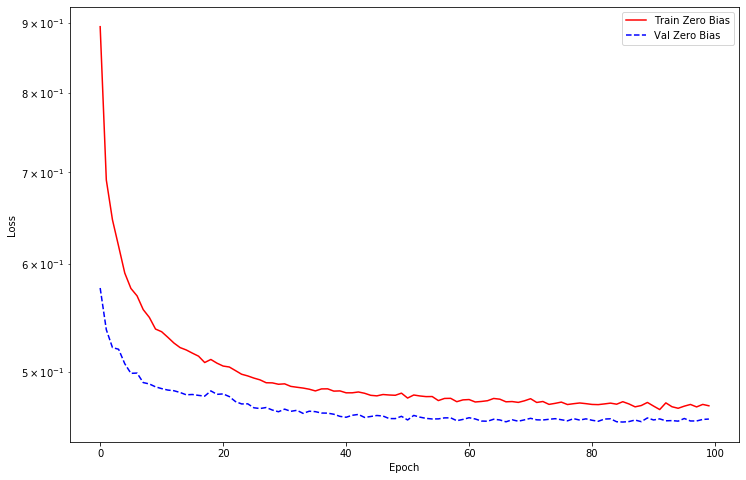

In [402]:
plot_loss(history_normal, "Zero Bias", 0)

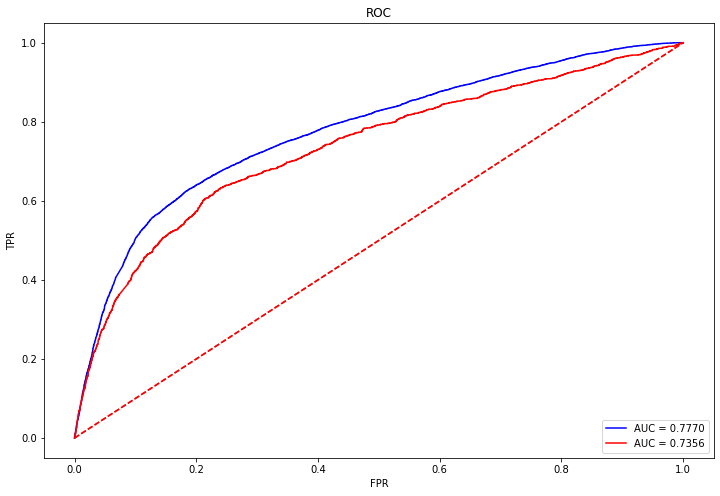

In [413]:
train_predictions_normal = model_normal.predict(X_train_norm)
test_predictions_normal = model_normal.predict(X_test_norm)

plt.figure(figsize=(12, 8))
plot_roc(y_train_norm, train_predictions_normal, 'b')
plot_roc(y_test_norm, test_predictions_normal, 'r')

In [404]:
X_train_upsample, X_test_upsample, y_train_upsample, y_test_upsample = up_sample(train_trd_comb, 0.2)

model_up = make_model()
history_up = model_up.fit(
    X_train_upsample,
    y_train_upsample,
    batch_size=200,
    epochs=100,
    validation_data=(X_test_upsample, y_test_upsample), 
    verbose=1)

Train on 49578 samples, validate on 7985 samples
Epoch 1/100
49578/49578 [==============================] - 8s 153us/sample - loss: 0.7589 - tp: 20451.0000 - fp: 18718.0000 - tn: 6071.0000 - fn: 4338.0000 - accuracy: 0.5350 - precision: 0.5221 - recall: 0.8250 - auc: 0.5636 - val_loss: 0.7288 - val_tp: 1485.0000 - val_fp: 4082.0000 - val_tn: 2099.0000 - val_fn: 319.0000 - val_accuracy: 0.4488 - val_precision: 0.2668 - val_recall: 0.8232 - val_auc: 0.6685
Epoch 2/100
49578/49578 [==============================] - 3s 62us/sample - loss: 0.6729 - tp: 19187.0000 - fp: 15302.0000 - tn: 9487.0000 - fn: 5602.0000 - accuracy: 0.5784 - precision: 0.5563 - recall: 0.7740 - auc: 0.6470 - val_loss: 0.6774 - val_tp: 1312.0000 - val_fp: 2874.0000 - val_tn: 3307.0000 - val_fn: 492.0000 - val_accuracy: 0.5785 - val_precision: 0.3134 - val_recall: 0.7273 - val_auc: 0.6923
Epoch 3/100
49578/49578 [==============================] - 3s 59us/sample - loss: 0.6495 - tp: 17817.0000 - fp: 12227.0000 - tn: 125

Epoch 21/100
49578/49578 [==============================] - 3s 61us/sample - loss: 0.6027 - tp: 14691.0000 - fp: 5460.0000 - tn: 19329.0000 - fn: 10098.0000 - accuracy: 0.6862 - precision: 0.7290 - recall: 0.5926 - auc: 0.7416 - val_loss: 0.6007 - val_tp: 1087.0000 - val_fp: 1425.0000 - val_tn: 4756.0000 - val_fn: 717.0000 - val_accuracy: 0.7317 - val_precision: 0.4327 - val_recall: 0.6025 - val_auc: 0.7357
Epoch 22/100
49578/49578 [==============================] - 3s 57us/sample - loss: 0.6032 - tp: 14811.0000 - fp: 5545.0000 - tn: 19244.0000 - fn: 9978.0000 - accuracy: 0.6869 - precision: 0.7276 - recall: 0.5975 - auc: 0.7420 - val_loss: 0.5928 - val_tp: 1079.0000 - val_fp: 1354.0000 - val_tn: 4827.0000 - val_fn: 725.0000 - val_accuracy: 0.7396 - val_precision: 0.4435 - val_recall: 0.5981 - val_auc: 0.7356
Epoch 23/100
49578/49578 [==============================] - 3s 60us/sample - loss: 0.6006 - tp: 14793.0000 - fp: 5451.0000 - tn: 19338.0000 - fn: 9996.0000 - accuracy: 0.6884 - pr

Epoch 41/100
49578/49578 [==============================] - 3s 57us/sample - loss: 0.5945 - tp: 14892.0000 - fp: 5221.0000 - tn: 19568.0000 - fn: 9897.0000 - accuracy: 0.6951 - precision: 0.7404 - recall: 0.6008 - auc: 0.7518 - val_loss: 0.5911 - val_tp: 1081.0000 - val_fp: 1316.0000 - val_tn: 4865.0000 - val_fn: 723.0000 - val_accuracy: 0.7446 - val_precision: 0.4510 - val_recall: 0.5992 - val_auc: 0.7395
Epoch 42/100
49578/49578 [==============================] - 3s 55us/sample - loss: 0.5933 - tp: 14923.0000 - fp: 5287.0000 - tn: 19502.0000 - fn: 9866.0000 - accuracy: 0.6944 - precision: 0.7384 - recall: 0.6020 - auc: 0.7516 - val_loss: 0.5972 - val_tp: 1091.0000 - val_fp: 1372.0000 - val_tn: 4809.0000 - val_fn: 713.0000 - val_accuracy: 0.7389 - val_precision: 0.4430 - val_recall: 0.6048 - val_auc: 0.7391
Epoch 43/100
49578/49578 [==============================] - 3s 63us/sample - loss: 0.5938 - tp: 14889.0000 - fp: 5179.0000 - tn: 19610.0000 - fn: 9900.0000 - accuracy: 0.6959 - pre

Epoch 61/100
49578/49578 [==============================] - 3s 64us/sample - loss: 0.5915 - tp: 14832.0000 - fp: 5006.0000 - tn: 19783.0000 - fn: 9957.0000 - accuracy: 0.6982 - precision: 0.7477 - recall: 0.5983 - auc: 0.7548 - val_loss: 0.5933 - val_tp: 1103.0000 - val_fp: 1316.0000 - val_tn: 4865.0000 - val_fn: 701.0000 - val_accuracy: 0.7474 - val_precision: 0.4560 - val_recall: 0.6114 - val_auc: 0.7376
Epoch 62/100
49578/49578 [==============================] - 3s 69us/sample - loss: 0.5909 - tp: 14881.0000 - fp: 5171.0000 - tn: 19618.0000 - fn: 9908.0000 - accuracy: 0.6959 - precision: 0.7421 - recall: 0.6003 - auc: 0.7546 - val_loss: 0.5871 - val_tp: 1069.0000 - val_fp: 1232.0000 - val_tn: 4949.0000 - val_fn: 735.0000 - val_accuracy: 0.7537 - val_precision: 0.4646 - val_recall: 0.5926 - val_auc: 0.7373
Epoch 63/100
49578/49578 [==============================] - 3s 65us/sample - loss: 0.5914 - tp: 14878.0000 - fp: 5129.0000 - tn: 19660.0000 - fn: 9911.0000 - accuracy: 0.6966 - pre

Epoch 81/100
49578/49578 [==============================] - 3s 67us/sample - loss: 0.5869 - tp: 14913.0000 - fp: 4969.0000 - tn: 19820.0000 - fn: 9876.0000 - accuracy: 0.7006 - precision: 0.7501 - recall: 0.6016 - auc: 0.7585 - val_loss: 0.5902 - val_tp: 1090.0000 - val_fp: 1258.0000 - val_tn: 4923.0000 - val_fn: 714.0000 - val_accuracy: 0.7530 - val_precision: 0.4642 - val_recall: 0.6042 - val_auc: 0.7385
Epoch 82/100
49578/49578 [==============================] - 4s 82us/sample - loss: 0.5868 - tp: 15127.0000 - fp: 5091.0000 - tn: 19698.0000 - fn: 9662.0000 - accuracy: 0.7024 - precision: 0.7482 - recall: 0.6102 - auc: 0.7589 - val_loss: 0.5813 - val_tp: 1044.0000 - val_fp: 1167.0000 - val_tn: 5014.0000 - val_fn: 760.0000 - val_accuracy: 0.7587 - val_precision: 0.4722 - val_recall: 0.5787 - val_auc: 0.7388
Epoch 83/100
49578/49578 [==============================] - 3s 59us/sample - loss: 0.5876 - tp: 14845.0000 - fp: 4998.0000 - tn: 19791.0000 - fn: 9944.0000 - accuracy: 0.6986 - pre

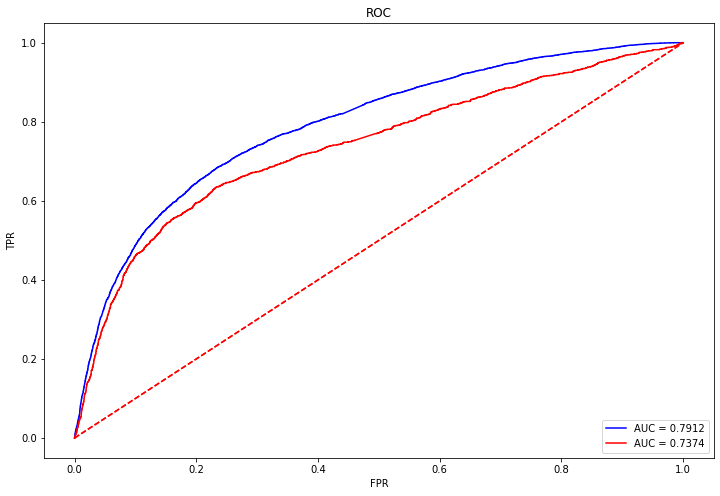

In [414]:
train_predictions_up = model_up.predict(X_train_upsample)
test_predictions_up = model_up.predict(X_test_upsample)

plt.figure(figsize=(12, 8))
plot_roc(y_train_upsample, train_predictions_up, 'b')
plot_roc(y_test_upsample, test_predictions_up, 'r')

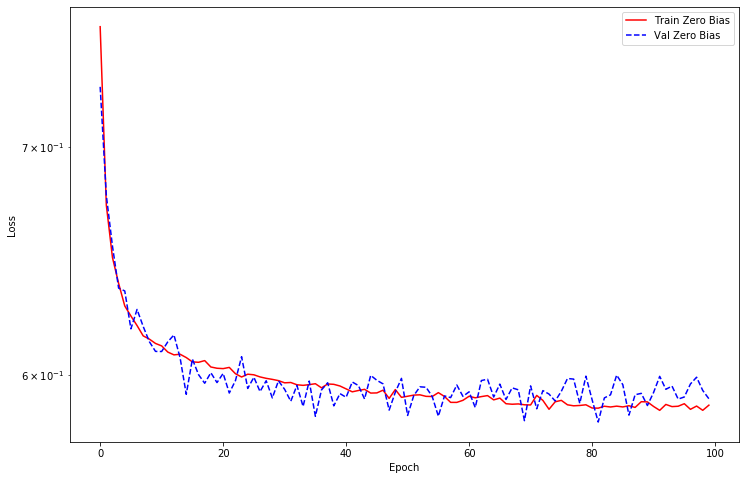

In [406]:
plot_loss(history_up, "Zero Bias", 0)

In [419]:
X_train_down, X_test_down, y_train_down, y_test_down = down_sample(train_trd_comb, 0.2)

model_down = make_model()
history_down = model_down.fit(
    X_train_down,
    y_train_down,
    batch_size=200,
    epochs=100,
    validation_data=(X_test_down, y_test_down), 
    verbose=1)

Train on 14186 samples, validate on 7985 samples
Epoch 1/100
14186/14186 [==============================] - 6s 429us/sample - loss: 0.8924 - tp: 5679.0000 - fp: 5303.0000 - tn: 1790.0000 - fn: 1414.0000 - accuracy: 0.5265 - precision: 0.5171 - recall: 0.8006 - auc: 0.5374 - val_loss: 0.8463 - val_tp: 1575.0000 - val_fp: 4638.0000 - val_tn: 1487.0000 - val_fn: 285.0000 - val_accuracy: 0.3835 - val_precision: 0.2535 - val_recall: 0.8468 - val_auc: 0.5913
Epoch 2/100
14186/14186 [==============================] - 2s 147us/sample - loss: 0.8045 - tp: 5174.0000 - fp: 4574.0000 - tn: 2519.0000 - fn: 1919.0000 - accuracy: 0.5423 - precision: 0.5308 - recall: 0.7295 - auc: 0.5605 - val_loss: 0.7786 - val_tp: 1548.0000 - val_fp: 4289.0000 - val_tn: 1836.0000 - val_fn: 312.0000 - val_accuracy: 0.4238 - val_precision: 0.2652 - val_recall: 0.8323 - val_auc: 0.6414
Epoch 3/100
14186/14186 [==============================] - 2s 112us/sample - loss: 0.7622 - tp: 5197.0000 - fp: 4388.0000 - tn: 2705.00

14186/14186 [==============================] - 2s 143us/sample - loss: 0.6135 - tp: 4729.0000 - fp: 2397.0000 - tn: 4696.0000 - fn: 2364.0000 - accuracy: 0.6644 - precision: 0.6636 - recall: 0.6667 - auc: 0.7262 - val_loss: 0.6117 - val_tp: 1168.0000 - val_fp: 1665.0000 - val_tn: 4460.0000 - val_fn: 692.0000 - val_accuracy: 0.7048 - val_precision: 0.4123 - val_recall: 0.6280 - val_auc: 0.7284
Epoch 41/100
14186/14186 [==============================] - 2s 132us/sample - loss: 0.6149 - tp: 4657.0000 - fp: 2320.0000 - tn: 4773.0000 - fn: 2436.0000 - accuracy: 0.6647 - precision: 0.6675 - recall: 0.6566 - auc: 0.7232 - val_loss: 0.6175 - val_tp: 1197.0000 - val_fp: 1750.0000 - val_tn: 4375.0000 - val_fn: 663.0000 - val_accuracy: 0.6978 - val_precision: 0.4062 - val_recall: 0.6435 - val_auc: 0.7291
Epoch 42/100
14186/14186 [==============================] - 2s 157us/sample - loss: 0.6192 - tp: 4682.0000 - fp: 2383.0000 - tn: 4710.0000 - fn: 2411.0000 - accuracy: 0.6621 - precision: 0.6627 -

Epoch 60/100
14186/14186 [==============================] - 2s 143us/sample - loss: 0.6094 - tp: 4410.0000 - fp: 1903.0000 - tn: 5190.0000 - fn: 2683.0000 - accuracy: 0.6767 - precision: 0.6986 - recall: 0.6217 - auc: 0.7300 - val_loss: 0.6124 - val_tp: 1174.0000 - val_fp: 1617.0000 - val_tn: 4508.0000 - val_fn: 686.0000 - val_accuracy: 0.7116 - val_precision: 0.4206 - val_recall: 0.6312 - val_auc: 0.7344
Epoch 61/100
14186/14186 [==============================] - 2s 142us/sample - loss: 0.6068 - tp: 4376.0000 - fp: 1857.0000 - tn: 5236.0000 - fn: 2717.0000 - accuracy: 0.6776 - precision: 0.7021 - recall: 0.6169 - auc: 0.7324 - val_loss: 0.6120 - val_tp: 1163.0000 - val_fp: 1601.0000 - val_tn: 4524.0000 - val_fn: 697.0000 - val_accuracy: 0.7122 - val_precision: 0.4208 - val_recall: 0.6253 - val_auc: 0.7344
Epoch 62/100
14186/14186 [==============================] - 2s 129us/sample - loss: 0.6078 - tp: 4389.0000 - fp: 1867.0000 - tn: 5226.0000 - fn: 2704.0000 - accuracy: 0.6778 - precis

14186/14186 [==============================] - 2s 128us/sample - loss: 0.6045 - tp: 4168.0000 - fp: 1648.0000 - tn: 5445.0000 - fn: 2925.0000 - accuracy: 0.6776 - precision: 0.7166 - recall: 0.5876 - auc: 0.7359 - val_loss: 0.6105 - val_tp: 1145.0000 - val_fp: 1480.0000 - val_tn: 4645.0000 - val_fn: 715.0000 - val_accuracy: 0.7251 - val_precision: 0.4362 - val_recall: 0.6156 - val_auc: 0.7371
Epoch 81/100
14186/14186 [==============================] - 2s 121us/sample - loss: 0.6020 - tp: 4159.0000 - fp: 1557.0000 - tn: 5536.0000 - fn: 2934.0000 - accuracy: 0.6834 - precision: 0.7276 - recall: 0.5864 - auc: 0.7388 - val_loss: 0.6081 - val_tp: 1144.0000 - val_fp: 1511.0000 - val_tn: 4614.0000 - val_fn: 716.0000 - val_accuracy: 0.7211 - val_precision: 0.4309 - val_recall: 0.6151 - val_auc: 0.7366
Epoch 82/100
14186/14186 [==============================] - 2s 138us/sample - loss: 0.6018 - tp: 4144.0000 - fp: 1617.0000 - tn: 5476.0000 - fn: 2949.0000 - accuracy: 0.6781 - precision: 0.7193 -

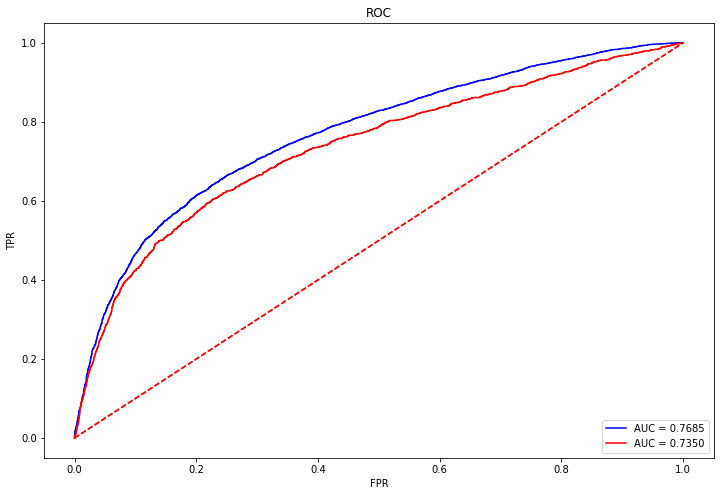

In [420]:
train_predictions_down = model_down.predict(X_train_down)
test_predictions_down = model_down.predict(X_test_down)

plt.figure(figsize=(12, 8))
plot_roc(y_train_down, train_predictions_down, 'b')
plot_roc(y_test_down, test_predictions_down, 'r')

In [409]:
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = SMOTE_sample(train_trd_comb, 0.2)

model_SMOTE = make_model()
history_SMOTE = model_SMOTE.fit(
    X_train_SMOTE,
    y_train_SMOTE,
    batch_size=200,
    epochs=100,
    validation_data=(X_test_SMOTE, y_test_SMOTE), 
    verbose=1)

Train on 49526 samples, validate on 7985 samples
Epoch 1/100
49526/49526 [==============================] - 7s 132us/sample - loss: 0.7529 - tp: 13436.0000 - fp: 9706.0000 - tn: 15057.0000 - fn: 11327.0000 - accuracy: 0.5753 - precision: 0.5806 - recall: 0.5426 - auc: 0.6015 - val_loss: 0.6303 - val_tp: 1015.0000 - val_fp: 1933.0000 - val_tn: 4274.0000 - val_fn: 763.0000 - val_accuracy: 0.6624 - val_precision: 0.3443 - val_recall: 0.5709 - val_auc: 0.6798
Epoch 2/100
49526/49526 [==============================] - 3s 57us/sample - loss: 0.6596 - tp: 13864.0000 - fp: 7718.0000 - tn: 17045.0000 - fn: 10899.0000 - accuracy: 0.6241 - precision: 0.6424 - recall: 0.5599 - auc: 0.6705 - val_loss: 0.6128 - val_tp: 985.0000 - val_fp: 1633.0000 - val_tn: 4574.0000 - val_fn: 793.0000 - val_accuracy: 0.6962 - val_precision: 0.3762 - val_recall: 0.5540 - val_auc: 0.6971
Epoch 3/100
49526/49526 [==============================] - 3s 57us/sample - loss: 0.6373 - tp: 14208.0000 - fp: 7025.0000 - tn: 177

Epoch 21/100
49526/49526 [==============================] - 3s 58us/sample - loss: 0.5958 - tp: 15401.0000 - fp: 6017.0000 - tn: 18746.0000 - fn: 9362.0000 - accuracy: 0.6895 - precision: 0.7191 - recall: 0.6219 - auc: 0.7499 - val_loss: 0.5858 - val_tp: 1062.0000 - val_fp: 1375.0000 - val_tn: 4832.0000 - val_fn: 716.0000 - val_accuracy: 0.7381 - val_precision: 0.4358 - val_recall: 0.5973 - val_auc: 0.7332
Epoch 22/100
49526/49526 [==============================] - 3s 57us/sample - loss: 0.5952 - tp: 15447.0000 - fp: 5912.0000 - tn: 18851.0000 - fn: 9316.0000 - accuracy: 0.6925 - precision: 0.7232 - recall: 0.6238 - auc: 0.7500 - val_loss: 0.5957 - val_tp: 1089.0000 - val_fp: 1458.0000 - val_tn: 4749.0000 - val_fn: 689.0000 - val_accuracy: 0.7311 - val_precision: 0.4276 - val_recall: 0.6125 - val_auc: 0.7326
Epoch 23/100
49526/49526 [==============================] - 3s 57us/sample - loss: 0.5942 - tp: 15530.0000 - fp: 5932.0000 - tn: 18831.0000 - fn: 9233.0000 - accuracy: 0.6938 - pre

Epoch 41/100
49526/49526 [==============================] - 3s 60us/sample - loss: 0.5859 - tp: 15564.0000 - fp: 5666.0000 - tn: 19097.0000 - fn: 9199.0000 - accuracy: 0.6999 - precision: 0.7331 - recall: 0.6285 - auc: 0.7608 - val_loss: 0.5833 - val_tp: 1056.0000 - val_fp: 1343.0000 - val_tn: 4864.0000 - val_fn: 722.0000 - val_accuracy: 0.7414 - val_precision: 0.4402 - val_recall: 0.5939 - val_auc: 0.7340
Epoch 42/100
49526/49526 [==============================] - 3s 59us/sample - loss: 0.5860 - tp: 15612.0000 - fp: 5642.0000 - tn: 19121.0000 - fn: 9151.0000 - accuracy: 0.7013 - precision: 0.7345 - recall: 0.6305 - auc: 0.7614 - val_loss: 0.5896 - val_tp: 1084.0000 - val_fp: 1428.0000 - val_tn: 4779.0000 - val_fn: 694.0000 - val_accuracy: 0.7343 - val_precision: 0.4315 - val_recall: 0.6097 - val_auc: 0.7346
Epoch 43/100
49526/49526 [==============================] - 3s 57us/sample - loss: 0.5858 - tp: 15588.0000 - fp: 5618.0000 - tn: 19145.0000 - fn: 9175.0000 - accuracy: 0.7013 - pre

Epoch 61/100
49526/49526 [==============================] - 3s 59us/sample - loss: 0.5819 - tp: 15637.0000 - fp: 5549.0000 - tn: 19214.0000 - fn: 9126.0000 - accuracy: 0.7037 - precision: 0.7381 - recall: 0.6315 - auc: 0.7649 - val_loss: 0.5819 - val_tp: 1058.0000 - val_fp: 1302.0000 - val_tn: 4905.0000 - val_fn: 720.0000 - val_accuracy: 0.7468 - val_precision: 0.4483 - val_recall: 0.5951 - val_auc: 0.7342
Epoch 62/100
49526/49526 [==============================] - 3s 61us/sample - loss: 0.5812 - tp: 15725.0000 - fp: 5573.0000 - tn: 19190.0000 - fn: 9038.0000 - accuracy: 0.7050 - precision: 0.7383 - recall: 0.6350 - auc: 0.7663 - val_loss: 0.5831 - val_tp: 1057.0000 - val_fp: 1325.0000 - val_tn: 4882.0000 - val_fn: 721.0000 - val_accuracy: 0.7438 - val_precision: 0.4437 - val_recall: 0.5945 - val_auc: 0.7331
Epoch 63/100
49526/49526 [==============================] - 3s 61us/sample - loss: 0.5828 - tp: 15661.0000 - fp: 5546.0000 - tn: 19217.0000 - fn: 9102.0000 - accuracy: 0.7042 - pre

Epoch 81/100
49526/49526 [==============================] - 3s 61us/sample - loss: 0.5811 - tp: 15644.0000 - fp: 5479.0000 - tn: 19284.0000 - fn: 9119.0000 - accuracy: 0.7052 - precision: 0.7406 - recall: 0.6317 - auc: 0.7659 - val_loss: 0.5894 - val_tp: 1063.0000 - val_fp: 1363.0000 - val_tn: 4844.0000 - val_fn: 715.0000 - val_accuracy: 0.7398 - val_precision: 0.4382 - val_recall: 0.5979 - val_auc: 0.7327
Epoch 82/100
49526/49526 [==============================] - 3s 62us/sample - loss: 0.5786 - tp: 15679.0000 - fp: 5505.0000 - tn: 19258.0000 - fn: 9084.0000 - accuracy: 0.7054 - precision: 0.7401 - recall: 0.6332 - auc: 0.7675 - val_loss: 0.5829 - val_tp: 1071.0000 - val_fp: 1308.0000 - val_tn: 4899.0000 - val_fn: 707.0000 - val_accuracy: 0.7477 - val_precision: 0.4502 - val_recall: 0.6024 - val_auc: 0.7326
Epoch 83/100
49526/49526 [==============================] - 3s 62us/sample - loss: 0.5795 - tp: 15750.0000 - fp: 5559.0000 - tn: 19204.0000 - fn: 9013.0000 - accuracy: 0.7058 - pre

In [70]:
from sklearn.metrics import roc_curve, auc
def plot_roc(labels, predict_prob, color):
    FPR, TPR,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(FPR, TPR)
    plt.title('ROC')
    plt.plot(FPR, TPR,color,label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

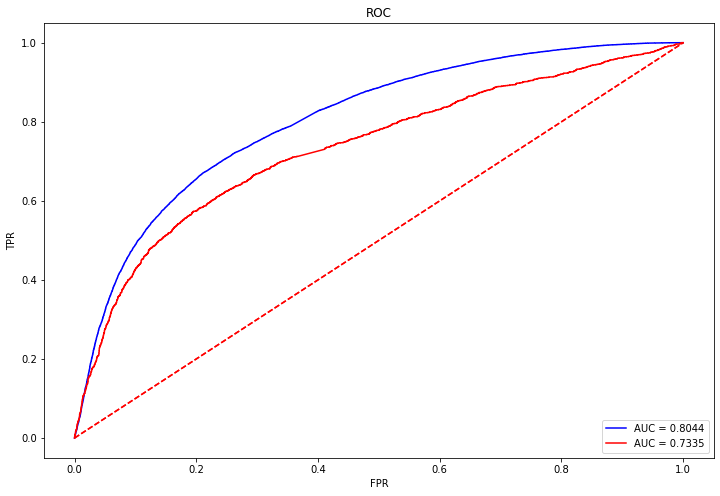

In [418]:
train_predictions_SMOTE = model_SMOTE.predict(X_train_SMOTE)
test_predictions_SMOTE = model_SMOTE.predict(X_test_SMOTE)

plt.figure(figsize=(12, 8))
plot_roc(y_train_SMOTE, train_predictions_SMOTE, 'b')
plot_roc(y_test_SMOTE, test_predictions_SMOTE, 'r')

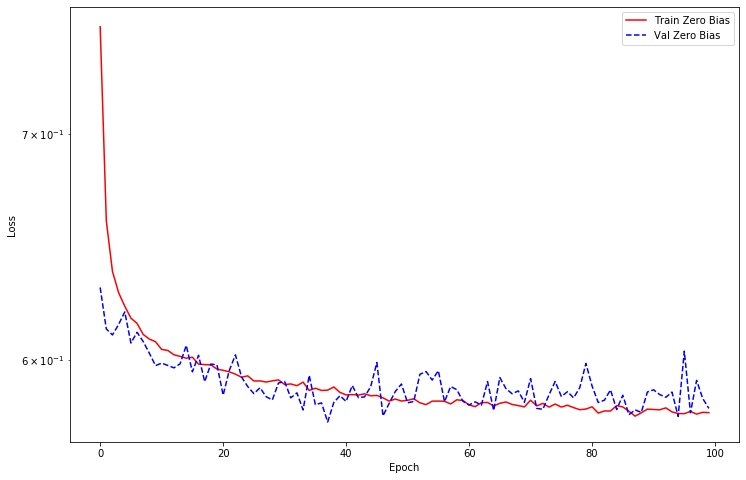

In [411]:
plot_loss(history_SMOTE, "Zero Bias", 0)

In [412]:
def proc_features(X, y):
    y_flag = np.array(y)
    X_features = np.array(X)
    bool_train_labels = X_features != 0
    
    #scaler = StandardScaler()
    #X_features = scaler.fit_transform(X_features)
    #X_features = np.clip(X_features, -5, 5)
    return X_features, y_flag

def proc_X(X):
    X_features = np.array(X)
    bool_train_labels = X_features != 0
    
    #scaler = StandardScaler()
    #X_features = scaler.fit_transform(X_features)
    #X_features = np.clip(X_features, -5, 5)
    return X_features

In [270]:
train_features, train_flag = proc_features(features, flag)

In [271]:
train_features.shape

(39923, 153)

In [272]:
X_train_SMOTE.shape

(49484, 153)

In [273]:
train_features, train_flag = proc_features(features, flag)

pred_train_normal = model_normal.predict(train_features)
pred_train_up = model_up.predict(train_features)
pred_train_down = model_down.predict(train_features)
pred_train_SMOTE = model_SMOTE.predict(train_features)

flag_ens = flag.copy()

flag_ens['pred_normal'] = pred_train_normal
flag_ens['pred_up'] = pred_train_up
flag_ens['pred_down'] = pred_train_down
flag_ens['pred_SMOTE'] = pred_train_SMOTE

In [274]:
flag_ens = flag.copy()

In [275]:
flag_ens['pred_normal'] = pred_train_normal
flag_ens['pred_up'] = pred_train_up
flag_ens['pred_down'] = pred_train_down
flag_ens['pred_SMOTE'] = pred_train_SMOTE

In [276]:
flag_ens

,flag,pred_normal,pred_up,pred_down,pred_SMOTE
0,0,0.127583,0.379192,0.368166,0.333846
1,0,0.138704,0.342243,0.423899,0.404234
2,0,0.112069,0.377554,0.204693,0.204549
3,0,0.130593,0.136093,0.371188,0.151287
4,0,0.118235,0.063036,0.260812,0.010429
...,...,...,...,...,...
39918,1,0.171953,0.402775,0.448931,0.348748
39919,0,0.141695,0.397598,0.447230,0.416871
39920,0,0.141800,0.395947,0.412191,0.405218
39921,0,0.139689,0.377904,0.416149,0.423642


In [277]:
X_interg = flag_ens.drop(['flag'], axis = 1)
y_interg = flag_ens[['flag']]

In [211]:
importances_ens[0]

0.3027677613451761

In [212]:
X_interg['pred_normal'] = X_interg['pred_normal']*importances_ens[0]
X_interg['pred_up'] = X_interg['pred_up']*importances_ens[1]
X_interg['pred_down'] = X_interg['pred_down']*importances_ens[2]
X_interg['pred_SMOTE'] = X_interg['pred_SMOTE']*importances_ens[3]

In [278]:
X_train_ing, X_test_ing, y_train_ing, y_test_ing = train_test_split(X_interg, y_interg, test_size=0.2)
#df_train = pd.concat([X_train, y_train], axis = 1)

In [362]:
def proc_dataset(X_train, X_test, y_train, y_test):
    y_train = np.array(y_train)
    bool_train_labels_norm = y_train != 0
    y_test = np.array(y_test)
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    
    #X_test = scaler.transform(X_test)
    #X_train = np.clip(X_train, -5, 5)
    #X_test = np.clip(X_test, -5, 5)
    return X_train, X_test, y_train, y_test

In [279]:
X_train_ing, X_test_ing, y_train_ing, y_test_ing = proc_dataset(X_train_ing, X_test_ing, y_train_ing, y_test_ing)

In [280]:
print('Training labels shape:', y_train_ing.shape)
#print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', y_test_ing.shape)

print('Training features shape:', X_train_ing.shape)
#print('Validation features shape:', val_features.shape)
print('Test features shape:', X_test_ing.shape)

Training labels shape: (31938, 1)
Test labels shape: (7985, 1)
Training features shape: (31938, 4)
Test features shape: (7985, 4)


In [281]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model_ens(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X_train_ing.shape[-1],)),
        keras.layers.Dropout(0.5),
        
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [282]:
model_ens = make_model_ens()
history_ens = model_ens.fit(
    X_train_ing,
    y_train_ing,
    batch_size=200,
    epochs=100,
    validation_data=(X_test_ing, y_test_ing), 
    verbose=1)

Train on 31938 samples, validate on 7985 samples
Epoch 1/100
31938/31938 [==============================] - 2s 76us/sample - loss: 0.4901 - tp: 1383.0000 - fp: 944.0000 - tn: 23870.0000 - fn: 5741.0000 - accuracy: 0.7907 - precision: 0.5943 - recall: 0.1941 - auc: 0.6913 - val_loss: 0.4473 - val_tp: 513.0000 - val_fp: 260.0000 - val_tn: 5896.0000 - val_fn: 1316.0000 - val_accuracy: 0.8026 - val_precision: 0.6636 - val_recall: 0.2805 - val_auc: 0.7709
Epoch 2/100
31938/31938 [==============================] - 1s 17us/sample - loss: 0.4563 - tp: 1949.0000 - fp: 1315.0000 - tn: 23499.0000 - fn: 5175.0000 - accuracy: 0.7968 - precision: 0.5971 - recall: 0.2736 - auc: 0.7552 - val_loss: 0.4451 - val_tp: 591.0000 - val_fp: 302.0000 - val_tn: 5854.0000 - val_fn: 1238.0000 - val_accuracy: 0.8071 - val_precision: 0.6618 - val_recall: 0.3231 - val_auc: 0.7719
Epoch 3/100
31938/31938 [==============================] - 1s 17us/sample - loss: 0.4502 - tp: 1993.0000 - fp: 1259.0000 - tn: 23555.0000 

Epoch 21/100
31938/31938 [==============================] - 1s 16us/sample - loss: 0.4407 - tp: 2377.0000 - fp: 1430.0000 - tn: 23384.0000 - fn: 4747.0000 - accuracy: 0.8066 - precision: 0.6244 - recall: 0.3337 - auc: 0.7680 - val_loss: 0.4419 - val_tp: 714.0000 - val_fp: 396.0000 - val_tn: 5760.0000 - val_fn: 1115.0000 - val_accuracy: 0.8108 - val_precision: 0.6432 - val_recall: 0.3904 - val_auc: 0.7745
Epoch 22/100
31938/31938 [==============================] - 1s 16us/sample - loss: 0.4415 - tp: 2341.0000 - fp: 1434.0000 - tn: 23380.0000 - fn: 4783.0000 - accuracy: 0.8053 - precision: 0.6201 - recall: 0.3286 - auc: 0.7671 - val_loss: 0.4421 - val_tp: 677.0000 - val_fp: 362.0000 - val_tn: 5794.0000 - val_fn: 1152.0000 - val_accuracy: 0.8104 - val_precision: 0.6516 - val_recall: 0.3701 - val_auc: 0.7747
Epoch 23/100
31938/31938 [==============================] - 1s 16us/sample - loss: 0.4397 - tp: 2348.0000 - fp: 1410.0000 - tn: 23404.0000 - fn: 4776.0000 - accuracy: 0.8063 - precisio

31938/31938 [==============================] - 1s 18us/sample - loss: 0.4402 - tp: 2464.0000 - fp: 1468.0000 - tn: 23346.0000 - fn: 4660.0000 - accuracy: 0.8081 - precision: 0.6267 - recall: 0.3459 - auc: 0.7690 - val_loss: 0.4419 - val_tp: 705.0000 - val_fp: 391.0000 - val_tn: 5765.0000 - val_fn: 1124.0000 - val_accuracy: 0.8103 - val_precision: 0.6432 - val_recall: 0.3855 - val_auc: 0.7751
Epoch 62/100
31938/31938 [==============================] - 1s 17us/sample - loss: 0.4400 - tp: 2433.0000 - fp: 1468.0000 - tn: 23346.0000 - fn: 4691.0000 - accuracy: 0.8072 - precision: 0.6237 - recall: 0.3415 - auc: 0.7697 - val_loss: 0.4419 - val_tp: 706.0000 - val_fp: 393.0000 - val_tn: 5763.0000 - val_fn: 1123.0000 - val_accuracy: 0.8101 - val_precision: 0.6424 - val_recall: 0.3860 - val_auc: 0.7751
Epoch 63/100
31938/31938 [==============================] - 1s 18us/sample - loss: 0.4412 - tp: 2349.0000 - fp: 1500.0000 - tn: 23314.0000 - fn: 4775.0000 - accuracy: 0.8035 - precision: 0.6103 - r

In [208]:
feat_labels = X_interg.columns
forest_ens = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
forest_ens.fit(X_train_ing, y_train_ing)

importances_ens = forest_ens.feature_importances_ # 特征重要性排名
indices_ens = np.argsort(importances_ens)[::-1]
for f in range(X_train_ing.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices_ens[f]], importances_ens[indices_ens[f]]))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


 1) pred_normal                    0.302768
 2) pred_up                        0.262675
 3) pred_down                      0.232687
 4) pred_SMOTE                     0.201870


In [283]:
print(np.mean(cross_val_score(forest_ens, np.array(X_interg), np.array(y_interg), cv=20, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.753031451917593


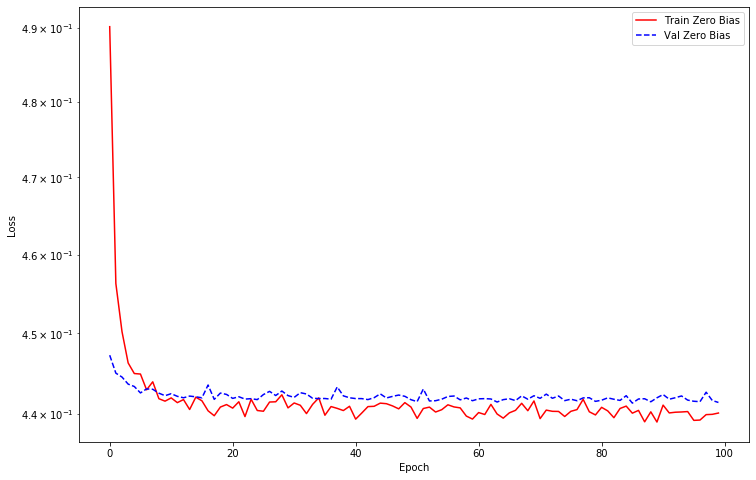

In [284]:
plot_loss(history_ens, "Zero Bias", 0)

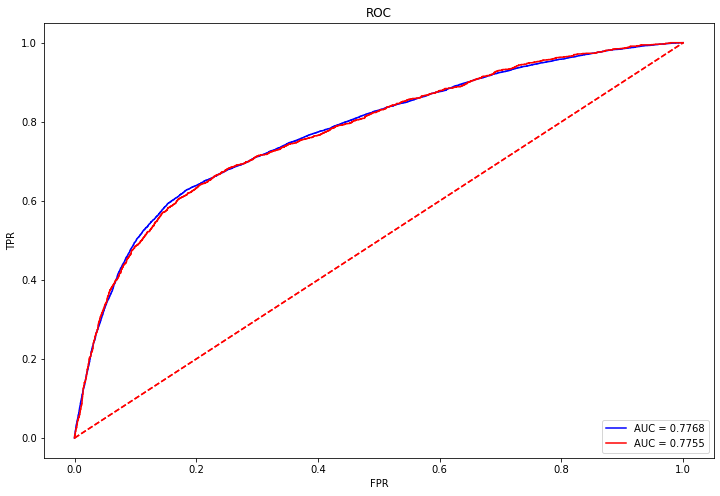

In [285]:
pred_train_ens = model_ens.predict(X_train_ing)
pred_test_ens = model_ens.predict(X_test_ing)

plt.figure(figsize=(12, 8))
plot_roc(y_train_ing, pred_train_ens, 'b')
plot_roc(y_test_ing, pred_test_ens, 'r')

# boosting

In [354]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn import  metrics
import xgboost as xgb

In [147]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = features.columns
forest = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
#forest = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_ # 特征重要性排名
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


 1) cur_credit_min_opn_dt_cnt      0.050022
 2) age                            0.040953
 3) l1y_crd_card_csm_amt_dlm_cd    0.036080
 4) le3_amount                     0.028867
 5) cur_debit_min_opn_dt_cnt       0.026818
 6) perm_crd_lmt_cd                0.026025
 7) job_year                       0.025318
 8) le1_amount                     0.023109
 9) B_amount                       0.021892
10) flow_amount                    0.021170
11) in_amo_min                     0.020689
12) in_amo_mean                    0.020641
13) in_total                       0.020428
14) in_amo_max                     0.019538
15) out_amo_max                    0.019103
16) out_amo_mean                   0.018209
17) out_total                      0.017904
18) out_amo_min                    0.017766
19) in_amo_std                     0.016229
20) B_num                          0.013901
21) out_amo_std                    0.013544
22) le3_num                        0.013233
23) cur_credit_cnt              

In [151]:
features_np = np.array(features)
flag_np = np.array(flag)

In [152]:
print(np.mean(cross_val_score(forest, features_np, flag_np, cv=20, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.6980726136952449


In [421]:
def bayesian_optimization(dataset, function, parameters):
    X_train, y_train, X_test, y_test = dataset
    n_iterations = 5
    gp_params = {"alpha": 1e-4}

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params)

    return BO.max

def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=42,   
                   class_weight="balanced"),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="roc_auc",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
    
    return function, parameters

In [422]:
def train_RF(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

    model.fit(X_train, y_train)
    
    return model

In [366]:
X_train_normal, X_test_normal, y_train_normal, y_test_normal = normal_set(train_trd_comb, 0.2)

In [367]:
"""
Four sampling dataset & rf
"""
forest_normal = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
forest_normal.fit(X_train, y_train)
print(np.mean(cross_val_score(forest_normal, X_test_normal, y_test_normal, cv=10, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 

0.707192783530125


In [423]:
X_train_normal, X_test_normal, y_train_normal, y_test_normal = normal_set(train_trd_comb, 0.2)
function_normrf, para_normrf = rfc_optimization(10)
model_normrf = train_RF(X_train_normal, y_train_normal, X_test_normal, y_test_normal, function_normrf, para_normrf)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.741    |  92.9     |  5.436    |  502.5    |
|  2        |  0.7401   |  74.22    |  9.485    |  320.5    |
|  3        |  0.7381   |  22.89    |  7.532    |  170.8    |
|  4        |  0.7407   |  141.0    |  3.381    |  940.3    |
|  5        |  0.7403   |  77.73    |  7.748    |  762.1    |
|  6        |  0.7113   |  147.3    |  5.158    |  12.09    |
|  7        |  0.7406   |  95.02    |  9.51     |  502.3    |
|  8        |  0.7171   |  5.85     |  4.535    |  997.4    |
|  9        |  0.741    |  148.7    |  5.828    |  999.7    |
|  10       |  0.6948   |  3.231    |  2.169    |  994.2    |


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [424]:
# rendom forest on upsampling
X_train_up, X_test_up, y_train_up, y_test_up = up_sample(train_trd_comb, 0.2)
function_uprf, para_uprf = rfc_optimization(10)
model_uprf = train_RF(X_train_up, y_train_up, X_test_up, y_test_up, function_uprf, para_uprf)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.7405   |  42.91    |  7.456    |  803.6    |
|  2        |  0.7392   |  86.28    |  7.855    |  328.0    |
|  3        |  0.7369   |  107.6    |  3.83     |  122.1    |
|  4        |  0.7376   |  136.5    |  8.569    |  95.09    |
|  5        |  0.7402   |  123.7    |  9.794    |  269.7    |
|  6        |  0.6314   |  1.201    |  9.178    |  999.2    |
|  7        |  0.7401   |  149.2    |  2.106    |  774.5    |
|  8        |  0.7203   |  7.926    |  5.102    |  10.49    |
|  9        |  0.6301   |  1.277    |  2.755    |  582.8    |
|  10       |  0.741    |  45.36    |  5.012    |  803.7    |


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [425]:
X_train_down, X_test_down, y_train_down, y_test_down = down_sample(train_trd_comb, 0.2)
function_downrf, para_downrf = rfc_optimization(10)
model_downrf = train_RF(X_train_down, y_train_down, X_test_down, y_test_down, function_downrf, para_downrf)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.7406   |  95.97    |  9.12     |  643.8    |
|  2        |  0.7402   |  85.1     |  8.76     |  764.6    |
|  3        |  0.741    |  61.61    |  5.43     |  967.8    |
|  4        |  0.7369   |  20.9     |  3.827    |  434.4    |
|  5        |  0.7402   |  28.62    |  5.213    |  923.1    |
|  6        |  0.7142   |  147.9    |  8.563    |  11.47    |
|  7        |  0.7402   |  146.7    |  4.154    |  999.7    |
|  8        |  0.707    |  4.267    |  3.833    |  997.5    |
|  9        |  0.7405   |  142.1    |  6.782    |  1e+03    |
|  10       |  0.7402   |  147.0    |  4.056    |  995.5    |


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [426]:
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = SMOTE_sample(train_trd_comb, 0.2)
function_SMOTErf, para_SMOTErf = rfc_optimization(10)
model_SMOTErf = train_RF(X_train_SMOTE, y_train_SMOTE, X_test_SMOTE, y_test_SMOTE, function_SMOTErf, para_SMOTErf)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------


D:\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


|  1        |  0.7401   |  142.2    |  4.448    |  763.7    |
|  2        |  0.7407   |  147.0    |  9.304    |  615.2    |
|  3        |  0.7402   |  91.12    |  6.457    |  817.0    |
|  4        |  0.7362   |  32.85    |  6.037    |  120.1    |
|  5        |  0.7398   |  106.1    |  6.77     |  447.4    |
|  6        |  0.6314   |  1.971    |  9.834    |  999.1    |
|  7        |  0.7119   |  143.1    |  3.55     |  14.53    |
|  8        |  0.675    |  2.386    |  5.864    |  610.4    |
|  9        |  0.7409   |  148.6    |  3.075    |  994.5    |
|  10       |  0.739    |  149.1    |  3.53     |  275.7    |


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


# XGBoost

In [428]:
X_train_normxgb, X_test_normxgb, y_train_normxgb, y_test_normxgb = normal_set(train_trd_comb, 0.2)

dtrain=xgb.DMatrix(X_train_normxgb,y_train_normxgb)
dtest=xgb.DMatrix(X_test_normxgb)

params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,
    'nthread':8,
     'silent':1}

model_normxgb=xgb.train(params,dtrain,num_boost_round=50)
#输出概率
y_normxgb_pred=model_normxgb.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test_normxgb,y_normxgb_pred))

test AUC: 0.7251


In [429]:
X_train_upxgb, X_test_upxgb, y_train_upxgb, y_test_upxgb = up_sample(train_trd_comb, 0.2)

dtrain=xgb.DMatrix(X_train_upxgb,y_train_upxgb)
dtest=xgb.DMatrix(X_test_upxgb)

params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,
    'nthread':8,
     'silent':1}

model_upxgb=xgb.train(params,dtrain,num_boost_round=50)
#输出概率
y_upxgb_pred=model_upxgb.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test_upxgb,y_upxgb_pred))

test AUC: 0.7204


In [435]:
X_train_downxgb, X_test_downxgb, y_train_downxgb, y_test_downxgb = down_sample(train_trd_comb, 0.2)

dtrain=xgb.DMatrix(X_train_downxgb,y_train_downxgb)
dtest=xgb.DMatrix(X_test_downxgb)

params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,
    'nthread':8,
     'silent':1}

model_downxgb=xgb.train(params,dtrain,num_boost_round=50)
#输出概率
y_downxgb_pred=model_downxgb.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test_downxgb,y_downxgb_pred))

test AUC: 0.7244


In [436]:
X_train_SMOTExgb, X_test_SMOTExgb, y_train_SMOTExgb, y_test_SMOTExgb = SMOTE_sample(train_trd_comb, 0.2)

dtrain=xgb.DMatrix(X_train_SMOTExgb,y_train_SMOTExgb)
dtest=xgb.DMatrix(X_test_SMOTExgb)

params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,
    'nthread':8,
     'silent':1}

model_SMOTExgb=xgb.train(params,dtrain,num_boost_round=50)
#输出概率
y_SMOTExgb_pred=model_SMOTExgb.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test_SMOTExgb,y_SMOTExgb_pred))

test AUC: 0.7101


In [375]:
def bayesian_optimization_xgb(X_train, y_train, X_test, y_test, function, parameters):
    #X_train, y_train, X_test, y_test = dataset
    n_iterations = 5
    gp_params = {"alpha": 1e-4}

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params)

    return BO.max

def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth):
            return cross_val_score(
                   xgb.XGBClassifier(
                       objective="binary:logistic",
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=int(max_depth),                                               
                       seed=42,
                       nthread=-1,
                       scale_pos_weight = len(y_train[y_train == 0])/
                                          len(y_train[y_train == 1])),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring="roc_auc",
                   fit_params={
                        "early_stopping_rounds": 10, 
                        "eval_metric": "auc", 
                        "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.001, 0.4),
                  "gamma": (0, 20),
                  "max_depth": (1, 2000)}
    
    return function, parameters

def train_xgb(X_train, y_train, X_test, y_test, function, parameters):
    #dataset = (X_train, y_train, X_test, y_test)
    
    dtrain=xgb.DMatrix(X_train,y_train)
    #dtest=xgb.DMatrix(X_test)
    
    cv_splits = 4
    
    best_solution = bayesian_optimization_xgb(X_train, y_train, X_test, y_test, function, parameters)      
    params = best_solution["params"]

    model = xgb.XGBClassifier(
                       objective="binary:logistic",
                       learning_rate=max(params['eta'], 0),
                       gamma=max(params['gamma'], 1),
                       max_depth=int(params['max_depth'], 2),                                               
                       seed=42,
                       nthread=-1,
                       scale_pos_weight = len(y_train[y_train == 0])/
                                          len(y_train[y_train == 1])),  
        
    model.train(params,dtrain,num_boost_round=50)
    #model.fit(X_train, y_train)
    
    return model

In [376]:
X_train_normxgb, X_test_normxgb, y_train_normxgb, y_test_normxgb = normal_set(train_trd_comb, 0.2)
dtrain_normxgb=xgb.DMatrix(X_train_normxgb,y_train_normxgb)
eval_normxgb = [(dtrain_normxgb,'train')]
function_normxgb, para_normxgb = xgb_optimization(5, eval_normxgb)
model_normxgb = train_xgb(X_train_normxgb, y_train_normxgb, X_test_normxgb, y_test_normxgb, function_normxgb, para_normxgb)

|   iter    |  target   |    eta    |   gamma   | max_depth |
-------------------------------------------------------------


PicklingError: Could not pickle the task to send it to the workers.

# Ada boost

In [ ]:
"""
param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
"""

def ada_optimization(cv_splits):
    def function(n_estimators, learning_rate):
        return cross_val_score(
               AdaBoostClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   learning_rate=int(max(learning_rate,1)),
                   algorithm = 'SAMME'
                   ),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="roc_auc",
               n_jobs=-1).mean()

    parameters = {'n_estimators': (10,1000),
                 'learning_rate' : (0.5,0.999)}
    
    return function, parameters

def train_ada(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = AdaBoostClassifier(
                   n_estimators=int(max(params["n_estimators"],0)),                                                               
                   learning_rate=int(max(params["learning_rate"],1)),
                   algorithm = 'SAMME'
                   )

    model.fit(X_train, y_train)
    
    return model

In [431]:
X_train_normada, X_test_normada, y_train_normada, y_test_normada = normal_set(train_trd_comb, 0.2)
ada_normal = AdaBoostClassifier(algorithm='SAMME',learning_rate=0.75, n_estimators=300)
ada_normal.fit(X_train_normada, y_train_normada)
print(np.mean(cross_val_score(ada_normal, X_test_normada, y_test_normada, cv=10, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

0.7227728955223707


In [432]:
X_train_downada, X_test_downada, y_train_downada, y_test_downada = down_sample(train_trd_comb, 0.2)
ada_down = AdaBoostClassifier(algorithm='SAMME',learning_rate=0.75, n_estimators=300)
ada_down.fit(X_train_downada, y_train_downada)
print(np.mean(cross_val_score(ada_down, X_test_downada, y_test_downada, cv=10, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

0.7355546979526381


In [438]:
X_train_upada, X_test_upada, y_train_upada, y_test_upada = up_sample(train_trd_comb, 0.2)
ada_up = AdaBoostClassifier(algorithm='SAMME',learning_rate=0.75, n_estimators=300)
ada_up.fit(X_train_upada, y_train_upada)
print(np.mean(cross_val_score(ada_up, X_test_upada, y_test_upada, cv=10, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

0.7257165228389841


In [434]:
X_train_SMOTEada, X_test_SMOTEada, y_train_SMOTEada, y_test_SMOTEada = SMOTE_sample(train_trd_comb, 0.2)
ada_SMOTE = AdaBoostClassifier(algorithm='SAMME',learning_rate=0.75, n_estimators=300)
ada_SMOTE.fit(X_train_SMOTEada, y_train_SMOTEada)
print(np.mean(cross_val_score(ada_SMOTE, X_test_SMOTEada, y_test_SMOTEada, cv=10, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

0.7257408490879358


In [439]:
flag

,flag
0,0
1,0
2,0
3,0
4,0
...,...
39918,1
39919,0
39920,0
39921,0


In [536]:
# train_features, train_flag = proc_features(features, flag)

pred_normANN = model_normal.predict(train_features)
pred_upANN = model_up.predict(train_features)
pred_downANN = model_down.predict(train_features)
pred_SMOTEANN = model_SMOTE.predict(train_features)

pred_normrf = model_normrf.predict(train_features)
pred_uprf = model_uprf.predict(train_features)
pred_downrf = model_downrf.predict(train_features)
pred_SMOTErf = model_SMOTErf.predict(train_features)

pred_normxgb = model_normxgb.predict(xgb.DMatrix(train_features))
pred_upxgb = model_upxgb.predict(xgb.DMatrix(train_features))
pred_downxgb = model_downxgb.predict(xgb.DMatrix(train_features))
pred_SMOTExgb = model_SMOTExgb.predict(xgb.DMatrix(train_features))

pred_normada = ada_normal.predict(train_features)
pred_upada = ada_up.predict(train_features)
pred_downada = ada_down.predict(train_features)
pred_SMOTEada = ada_SMOTE.predict(train_features)

flag_ens = flag.copy()

flag_ens['pred_normalANN'] = pred_normANN
flag_ens['pred_upANN'] = pred_upANN
flag_ens['pred_downANN'] = pred_downANN
flag_ens['pred_SMOTEANN'] = pred_SMOTEANN

flag_ens['pred_normrf'] = pred_normrf
flag_ens['pred_uprf'] = pred_uprf
flag_ens['pred_downrf'] = pred_downrf
#flag_ens['pred_SMOTErf'] = pred_SMOTErf

flag_ens['pred_normada'] = pred_normada
flag_ens['pred_upada'] = pred_upada
flag_ens['pred_downada'] = pred_downada
#flag_ens['pred_SMOTEada'] = pred_SMOTEada

flag_ens['pred_normxgb'] = pred_normxgb
flag_ens['pred_upxgb'] = pred_upxgb
flag_ens['pred_downxgb'] = pred_downxgb
flag_ens['pred_SMOTExgb'] = pred_SMOTExgb

In [443]:
flag_ens

,flag,pred_normalANN,pred_upANN,pred_downANN,pred_SMOTEANN,pred_normrf,pred_uprf,pred_downrf,pred_SMOTErf,pred_normada,pred_upada,pred_downada,pred_SMOTEada,pred_normxgb,pred_upxgb,pred_downxgb,pred_SMOTExgb
0,0,0.130571,0.286272,0.296289,0.176407,0,0,0,0,0,0,0,0,0.231994,0.382797,0.389511,0.338034
1,0,0.139851,0.349642,0.384885,0.317575,0,0,0,0,0,0,0,0,0.292002,0.448585,0.448801,0.412621
2,0,0.061395,0.218491,0.250831,0.032616,0,0,0,0,0,0,0,0,0.231994,0.374617,0.362296,0.297006
3,0,0.115346,0.235910,0.249616,0.217284,0,0,0,0,0,0,0,0,0.244127,0.377767,0.400432,0.338692
4,0,0.031729,0.054317,0.114330,0.120208,0,0,0,0,0,0,0,0,0.233334,0.374283,0.354434,0.267939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39918,1,0.185745,0.392247,0.469805,0.442315,1,0,1,1,0,0,0,0,0.294627,0.464883,0.457212,0.403185
39919,0,0.171865,0.377468,0.384326,0.365719,0,0,0,0,0,0,0,0,0.303883,0.474793,0.479663,0.399545
39920,0,0.164463,0.358481,0.413425,0.424886,0,0,0,0,0,0,0,0,0.285175,0.427743,0.430649,0.378131
39921,0,0.159881,0.379059,0.418661,0.383324,0,0,0,0,0,0,0,0,0.278043,0.443952,0.449903,0.401904


In [537]:
features1 = flag_ens.drop(['flag'], axis = 1)
features1 = (features1 - features1.mean()) / features1.std()
flag1 = flag_ens[['flag']]
features1, flag1 = proc_features(features1, flag1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, flag1, test_size=0.2)

In [ ]:
function_ensrf, para_ensrf = rfc_optimization(10)
model_ensrf = train_RF(X_train_ens, y_train_ens, X_test_ens, y_test_ens, function_ensrf, para_ensrf)

In [504]:
lg = LogisticRegression()
lg.fit(X_train1, y_train1)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

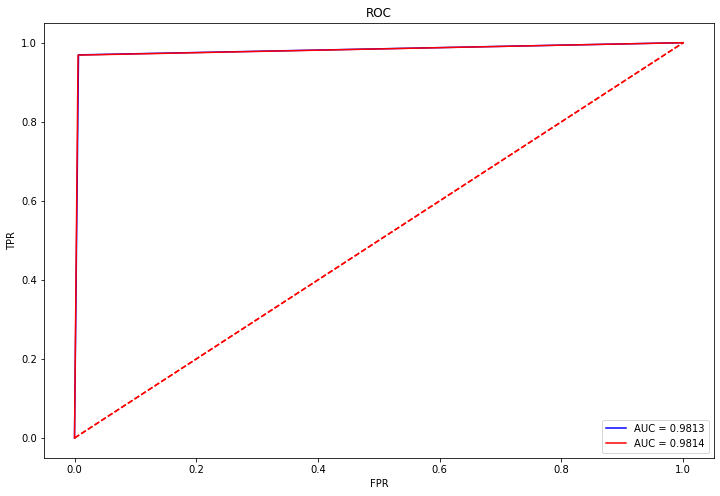

In [505]:
pred_train_ens = lg.predict(X_train1)
pred_test_ens = lg.predict(X_test1)

plt.figure(figsize=(12, 8))
plot_roc(y_train1, pred_train_ens, 'b')
plot_roc(y_test1, pred_test_ens, 'r')

In [485]:
import lightgbm as lgb

In [491]:
y_train1.shape

(31938, 1)

In [538]:
#X_train_ens = X_train1.values
#X_test_ens = X_test1.values
y_train_ens = y_train1.ravel()
y_test_ens = y_test1.ravel()
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.05,n_estimators=20)
gbm.fit(X_train1, y_train_ens,eval_set=[(X_test1, y_test_ens)],eval_metric='roc_auc',early_stopping_rounds=5)

[1]	valid_0's l2: 0.159934
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.145809
[3]	valid_0's l2: 0.13309
[4]	valid_0's l2: 0.121596
[5]	valid_0's l2: 0.11121
[6]	valid_0's l2: 0.101858
[7]	valid_0's l2: 0.0933971
[8]	valid_0's l2: 0.085756
[9]	valid_0's l2: 0.0788916
[10]	valid_0's l2: 0.072688
[11]	valid_0's l2: 0.0670863
[12]	valid_0's l2: 0.0620414
[13]	valid_0's l2: 0.0575017
[14]	valid_0's l2: 0.0533821
[15]	valid_0's l2: 0.0496681
[16]	valid_0's l2: 0.0463175
[17]	valid_0's l2: 0.0433041
[18]	valid_0's l2: 0.0405907
[19]	valid_0's l2: 0.0381094
[20]	valid_0's l2: 0.0359019
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.0359019


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=20, n_jobs=-1, num_leaves=31, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [520]:
y_pred = gbm.predict(X_test1)

In [495]:
y_pred

array([0.09705338, 0.08155791, 0.08155791, ..., 0.08155791, 0.08155791,
       0.08155791])

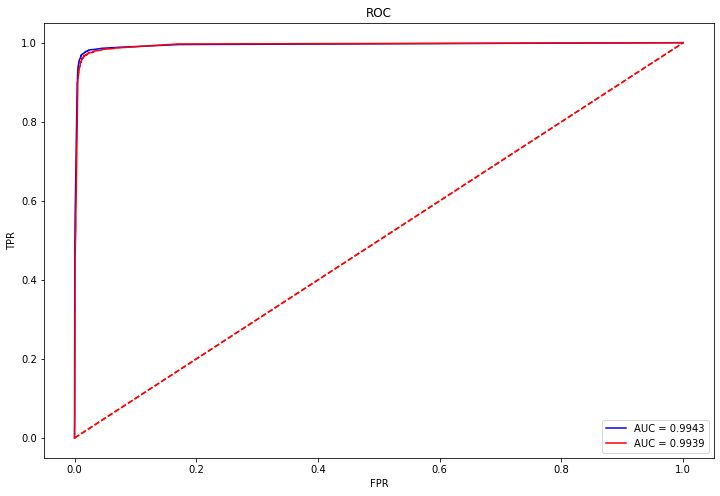

In [540]:
pred_train_ens = gbm.predict(X_train1)
pred_test_ens = gbm.predict(X_test1)

plt.figure(figsize=(12, 8))
plot_roc(y_train1, pred_train_ens, 'b')
plot_roc(y_test1, pred_test_ens, 'r')

In [467]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model_ens(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X_train1.shape[-1],)),
        keras.layers.Dropout(0.5),
        
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

model_ens = make_model_ens()
history_ens = model_ens.fit(
    X_train1,
    y_train1,
    batch_size=200,
    epochs=100,
    validation_data=(X_test1, y_test1), 
    verbose=1)

Train on 31938 samples, validate on 7985 samples
Epoch 1/100
31938/31938 [==============================] - 4s 127us/sample - loss: 0.4179 - tp: 4708.0000 - fp: 3848.0000 - tn: 20921.0000 - fn: 2461.0000 - accuracy: 0.8025 - precision: 0.5503 - recall: 0.6567 - auc: 0.8513 - val_loss: 0.2002 - val_tp: 1497.0000 - val_fp: 131.0000 - val_tn: 6070.0000 - val_fn: 287.0000 - val_accuracy: 0.9477 - val_precision: 0.9195 - val_recall: 0.8391 - val_auc: 0.9801
Epoch 2/100
31938/31938 [==============================] - 1s 35us/sample - loss: 0.1724 - tp: 6230.0000 - fp: 700.0000 - tn: 24069.0000 - fn: 939.0000 - accuracy: 0.9487 - precision: 0.8990 - recall: 0.8690 - auc: 0.9791 - val_loss: 0.1013 - val_tp: 1648.0000 - val_fp: 101.0000 - val_tn: 6100.0000 - val_fn: 136.0000 - val_accuracy: 0.9703 - val_precision: 0.9423 - val_recall: 0.9238 - val_auc: 0.9923
Epoch 3/100
31938/31938 [==============================] - 1s 40us/sample - loss: 0.1166 - tp: 6585.0000 - fp: 507.0000 - tn: 24262.0000 -

31938/31938 [==============================] - 1s 36us/sample - loss: 0.0678 - tp: 6871.0000 - fp: 308.0000 - tn: 24461.0000 - fn: 298.0000 - accuracy: 0.9810 - precision: 0.9571 - recall: 0.9584 - auc: 0.9930 - val_loss: 0.0610 - val_tp: 1707.0000 - val_fp: 72.0000 - val_tn: 6129.0000 - val_fn: 77.0000 - val_accuracy: 0.9813 - val_precision: 0.9595 - val_recall: 0.9568 - val_auc: 0.9944
Epoch 42/100
31938/31938 [==============================] - 1s 36us/sample - loss: 0.0673 - tp: 6853.0000 - fp: 289.0000 - tn: 24480.0000 - fn: 316.0000 - accuracy: 0.9811 - precision: 0.9595 - recall: 0.9559 - auc: 0.9930 - val_loss: 0.0609 - val_tp: 1715.0000 - val_fp: 82.0000 - val_tn: 6119.0000 - val_fn: 69.0000 - val_accuracy: 0.9811 - val_precision: 0.9544 - val_recall: 0.9613 - val_auc: 0.9946
Epoch 43/100
31938/31938 [==============================] - 1s 37us/sample - loss: 0.0687 - tp: 6850.0000 - fp: 298.0000 - tn: 24471.0000 - fn: 319.0000 - accuracy: 0.9807 - precision: 0.9583 - recall: 0.9

31938/31938 [==============================] - 1s 37us/sample - loss: 0.0669 - tp: 6848.0000 - fp: 289.0000 - tn: 24480.0000 - fn: 321.0000 - accuracy: 0.9809 - precision: 0.9595 - recall: 0.9552 - auc: 0.9928 - val_loss: 0.0607 - val_tp: 1709.0000 - val_fp: 76.0000 - val_tn: 6125.0000 - val_fn: 75.0000 - val_accuracy: 0.9811 - val_precision: 0.9574 - val_recall: 0.9580 - val_auc: 0.9946
Epoch 82/100
31938/31938 [==============================] - 1s 36us/sample - loss: 0.0658 - tp: 6846.0000 - fp: 290.0000 - tn: 24479.0000 - fn: 323.0000 - accuracy: 0.9808 - precision: 0.9594 - recall: 0.9549 - auc: 0.9931 - val_loss: 0.0609 - val_tp: 1715.0000 - val_fp: 78.0000 - val_tn: 6123.0000 - val_fn: 69.0000 - val_accuracy: 0.9816 - val_precision: 0.9565 - val_recall: 0.9613 - val_auc: 0.9946
Epoch 83/100
31938/31938 [==============================] - 1s 40us/sample - loss: 0.0658 - tp: 6850.0000 - fp: 295.0000 - tn: 24474.0000 - fn: 319.0000 - accuracy: 0.9808 - precision: 0.9587 - recall: 0.9

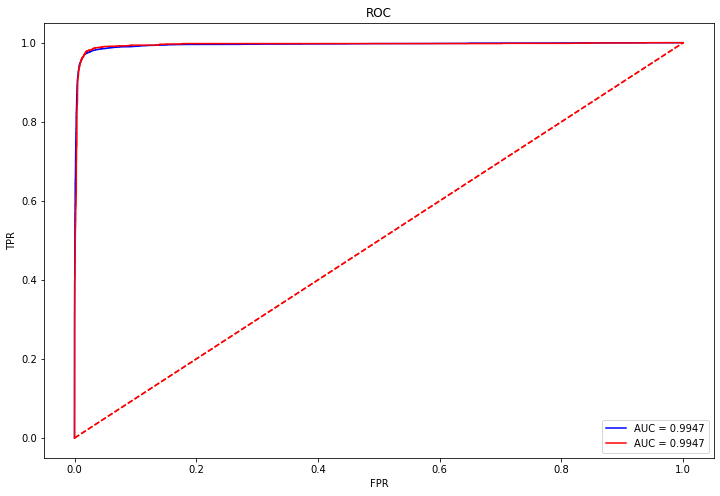

In [469]:
pred_train_ens = model_ens.predict(X_train1)
pred_test_ens = model_ens.predict(X_test1)

plt.figure(figsize=(12, 8))
plot_roc(y_train1, pred_train_ens, 'b')
plot_roc(y_test1, pred_test_ens, 'r')

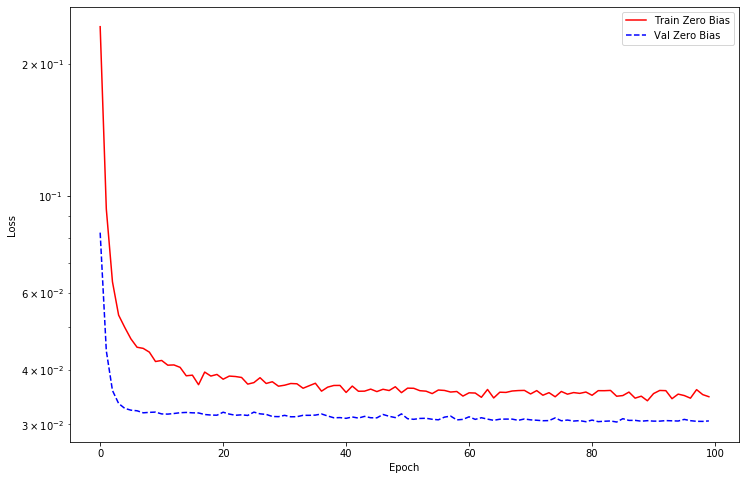

In [449]:
plot_loss(history_ens, "Zero Bias", 0)

# GDB

In [394]:
gbc_normal = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [395]:
X_train_normgdb, X_test_normgdb, y_train_normgdb, y_test_normgdb = normal_set(train_trd_comb, 0.2)
#function_normgdb, para_normgdb = ada_optimization(5)
gbc_normal.fit(X_train_normgdb, y_train_normgdb)
print(np.mean(cross_val_score(gdb_normal, X_test_normgdb, y_test_normgdb, cv=10, scoring='roc_auc')))

#model_normada = train_ada(X_train_normada, y_train_normada, X_test_normada, y_test_normada, function_normada, para_normada)

D:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


NameError: name 'gdb_normal' is not defined

In [396]:
print(np.mean(cross_val_score(gbc_normal, X_test_normgdb, y_test_normgdb, cv=10, scoring='roc_auc')))

D:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress th

0.6910793946734699


In [399]:
def gdb_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split,learning_rate):
        return cross_val_score(
               GradientBoostingClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)),
                   learning_rate=int(max(learning_rate, 3)),
                   min_samples_leaf=1, 
                   presort='auto',
                   loss = 'deviance'),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="roc_auc",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10),
                  "learning_rate": (0.2, 0.999)}
    
    return function, parameters

def train_gdb(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = GradientBoostingClassifier(
                   n_estimators=int(max(params['n_estimators'],0)),                                                               
                   max_depth=int(max(params['max_depth'],1)),
                   min_samples_split=int(max(params['min_samples_split'],2)),
                   learning_rate=int(max(params['learning_rate'], 3)),
                   min_samples_leaf=1, 
                   presort='auto',
                   loss = 'deviance')

    model.fit(X_train, y_train)
    
    return model

In [400]:
X_train_normgdb, X_test_normgdb, y_train_normgdb, y_test_normgdb = normal_set(train_trd_comb, 0.2)
function_normgdb, para_normgdb = gdb_optimization(5)
model_normgdb = train_gdb(X_train_normgdb, y_train_normgdb, X_test_normgdb, y_test_normgdb, function_normgdb, para_normgdb)

|   iter    |  target   | learni... | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.5512   |  0.5576   |  37.05    |  9.181    |  412.3    |


KeyboardInterrupt: 

# result

In [451]:
result_df3

,id,gdr_cd,age,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,mrg_situ_cd_A,mrg_situ_cd_B,mrg_situ_cd_O,mrg_situ_cd_Z,mrg_situ_cd_\N,mrg_situ_cd_~,edu_deg_cd_A,edu_deg_cd_B,edu_deg_cd_C,edu_deg_cd_D,edu_deg_cd_F,edu_deg_cd_G,edu_deg_cd_K,edu_deg_cd_L,edu_deg_cd_M,edu_deg_cd_Z,edu_deg_cd_\N,edu_deg_cd_~,acdm_deg_cd_30,acdm_deg_cd_31,acdm_deg_cd_C,acdm_deg_cd_D,acdm_deg_cd_F,acdm_deg_cd_G,acdm_deg_cd_Z,acdm_deg_cd_\N,deg_cd_A,deg_cd_B,deg_cd_C,deg_cd_D,deg_cd_Z,deg_cd_\N,deg_cd_nan,deg_cd_~,unipage_num,max_interval,min_daytime,max_daytime,sum_daytime,count_login_days,"(page_tm, sum)","(EGA_num, sum)","(XAG_num, sum)","(MTA_num, sum)","(LCT_num, sum)","(MSG_num, sum)","(JJD_num, sum)","(AAO_num, sum)","(FTR_num, sum)","(CTR_num, sum)","(XAI_num, sum)","(JF2_num, sum)","(SYK_num, sum)","(BWA_num, sum)","(ZY1_num, sum)","(SZA_num, sum)","(GBA_num, sum)","(TRN_num, sum)","(EGB_num, sum)","(LC0_num, sum)","(BWE_num, sum)","(SZD_num, sum)","(CQC_num, sum)","(CQB_num, sum)","(CQA_num, sum)","(CQD_num, sum)","(FLS_num, sum)","(FDA_num, sum)","(CQE_num, sum)","(JJK_num, sum)",sequel_max,sequel_min,"(page_time, min)","(page_time, max)","(page_time, std)","(page_time, mean)","(unipage, min)","(unipage, max)","(unipage, std)","(unipage, mean)",out_num,out_total,out_amo_mean,out_amo_max,out_amo_min,out_amo_std,out_con_total,out_con_mean,out_con_max,out_con_min,out_con_std,in_num,in_total,in_amo_mean,in_amo_max,in_amo_min,in_amo_std,in_con_total,in_con_mean,in_con_max,in_con_min,in_con_std,flow_amount,flow_num,A_num,A_amount,B_num,B_amount,C_num,C_amount,le1_num,le1_amount,le2_num,le2_amount,le3_num,le3_amount
0,U1E63A3,0,40,1,0,1,0,1,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,25,1,5,0,7,1,1,4047,4260,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0 days,00:00:00,00:00:00,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days,0 days,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,27.0,-48446.49,-4404.226364,-1269.62,-8985.00,2158.563179,27.0,2.454545,4.0,1.0,1.293340,4.0,27269.00,6817.250000,9000.00,5269.00,1618.926676,4.0,1.000000,1.0,1.0,0.000000,-21177.49,31.0,0.0,0.00,31.0,-21177.49,0.0,0.0,17.0,-30669.13,0.0,0.00,14.0,9491.64
1,U3EC77F,0,46,3,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,10,0,0,0,4,2,1,5460,3317,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0 days,00:00:00,00:00:00,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days,0 days,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00
2,U27DC0C,0,42,3,0,0,1,1,1,0,0,-1,0,-1,-1,1,2,-1,3,0,0,0,0,0,0,0,0,0,10,1,5,1,7,3,2,4103,4108,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,15 days,00:00:00,16:34:19,2 days 21:40:41,12.0,68.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,41.0,0

In [506]:
features_result = result_df3.drop(['id'], axis = 1)
features_result = (features_result - features_result.mean()) / features_result.std()

features_result = np.array(features_result)

#scaler = StandardScaler()
#features_result = scaler.fit_transform(features_result)

#features_result = np.clip(features_result, -5, 5)

print('X shape:', features_result.shape)

X shape: (4000, 153)


In [544]:
id_result = result_df3[['id']]

In [545]:
pred_normANNr = model_normal.predict(features_result)
pred_upANNr = model_up.predict(features_result)
pred_downANNr = model_down.predict(features_result)
pred_SMOTEANNr = model_SMOTE.predict(features_result)

pred_normrfr = model_normrf.predict(features_result)
pred_uprfr = model_uprf.predict(features_result)
pred_downrfr = model_downrf.predict(features_result)
pred_SMOTErfr = model_SMOTErf.predict(features_result)

pred_normxgbr = model_normxgb.predict(xgb.DMatrix(features_result))
pred_upxgbr = model_upxgb.predict(xgb.DMatrix(features_result))
pred_downxgbr = model_downxgb.predict(xgb.DMatrix(features_result))
pred_SMOTExgbr = model_SMOTExgb.predict(xgb.DMatrix(features_result))

pred_normadar = ada_normal.predict(features_result)
pred_upadar = ada_up.predict(features_result)
pred_downadar = ada_down.predict(features_result)
pred_SMOTEadar = ada_SMOTE.predict(features_result)

id_result_ens = id_result.copy()

id_result_ens['pred_normalANN'] = pred_normANNr
id_result_ens['pred_upANN'] = pred_upANNr
id_result_ens['pred_downANN'] = pred_downANNr
id_result_ens['pred_SMOTEANN'] = pred_SMOTEANNr

id_result_ens['pred_normrf'] = pred_normrfr
id_result_ens['pred_uprf'] = pred_uprfr
id_result_ens['pred_downrf'] = pred_downrfr
#id_result_ens['pred_SMOTErf'] = pred_SMOTErfr

id_result_ens['pred_normada'] = pred_normadar
id_result_ens['pred_upada'] = pred_upadar
id_result_ens['pred_downada'] = pred_downadar
#id_result_ens['pred_SMOTEada'] = pred_SMOTEadar

id_result_ens['pred_normxgb'] = pred_normxgbr
id_result_ens['pred_upxgb'] = pred_upxgbr
id_result_ens['pred_downxgb'] = pred_downxgbr
id_result_ens['pred_SMOTExgb'] = pred_SMOTExgbr

In [546]:
re_ens_X = id_result_ens.drop(['id'], axis = 1)
re_ens_X = (re_ens_X - re_ens_X.mean()) / re_ens_X.std()
re_ens_X = proc_X(re_ens_X)

In [547]:
result_predictions = gbm.predict(re_ens_X)

In [548]:
id_result['pred'] = result_predictions
id_result_final = id_result[['id', 'pred']]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [549]:
id_result_final

,id,pred
0,U1E63A3,0.081191
1,U3EC77F,0.081191
2,U27DC0C,0.081191
3,U3FAAAC,0.081191
4,U04EA0B,0.081191
...,...,...
3995,U0FBFE2,0.081191
3996,U506AD2,0.081191
3997,U287B33,0.081191
3998,U15134F,0.081191


In [550]:
import codecs

In [551]:
file = codecs.open('result_5.txt','w','utf-8')
for index, row in id_result_final.iterrows():
    print(row["id"], row["pred"], file = file)
file.close()